In [1]:
from functions import *
import numpy as np
import pandas as pd
import matplotlib
import os
import h5py
from scipy.constants import c, pi
import matplotlib.pyplot as plt

In [2]:
font = {'family' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)

In [3]:
class Conversion_efficiency(object):

    def __init__(self, freq_band, possition, filename=None, filepath='',filename2 = 'CE',filepath2 = 'output_dump/'):
        
        self.spec, self.fv, self.t, self.P0_p, self.P0_s,self.f_p, self.f_s, self.P_bef =\
            self.load_spectrum(possition,filename, filepath)
        self.nt = np.shape(self.spec)[0]
        fv_id = self.pos_of_idler()
        self.fv_id = fv_id
        self.start, self.end= self.fv[fv_id] - freq_band, self.fv[fv_id] + freq_band
        self.P_in = self.P0_p + self.P0_s
        self.P_out = self.calc_P_out()
        print(1e-3*c/self.f_p,1e-3*c/self.fv[self.fv_id],self.P0_p,self.spec[self.fv_id] )
        self.CE = self.calc_CE()
        self.read_write_CE_table(filename2,var = None, P_p = self.P0_p, P_s = self.P0_s, f_p = self.f_p,
                                         f_s = self.f_s,P_out = self.P_out,P_bef = self.P_bef, CE = self.CE, var2 = 'CE',file_path=filepath2)
        #print(np.shape(self.fv))
        #print(1e-3*c/self.fv[0] - 1e-3*c/self.fv[1])
        fig = plt.figure(figsize=(20.0, 10.0))
        plt.plot(1e-3*c/self.fv,w2dbm(self.spec[:,0,0]))
        plt.show()
        return None

    
    def pos_of_idler(self):
        plom = self.nt//2+10
        fv_id = np.where(self.spec[plom:,0,0] == np.max(self.spec[plom:,0,0]))[0][0]
        
        fv_id += plom
        return fv_id
    
    
    def load_spectrum(self, possition,filename='data_large', filepath=''):
        with h5py.File(filepath+filename+'.hdf5','r') as f: 
            l = f.get(possition)
            for i in l.keys():
                steady_state = i 
            layers = possition + '/' + steady_state
            D = read_variables(filename,layers, filepath)
            fv = D['fv']
            U = D['U']


            Uabs = np.real(D['Uabs'])
            P0_s = D['P0_s']
            P0_p = D['P0_p']
            t = D['t']
            f_p = D['f_p']
            f_s = D['f_s']
            layers = '1/0'
            D = read_variables(filename,layers, filepath)
            u = D['u']
            tt = D['t']
            #print(np.shape(u))
            P_bef = simps(np.abs(u[:,0,0])**2,tt)
            P_bef /=2*np.max(tt)
        return dbm2w(Uabs), fv,t, P0_p, P0_s, f_p, f_s,P_bef



    def calc_P_out(self):
        i = np.where(
            np.abs(self.fv - self.start) == np.min(np.abs(self.fv - self.start)))[0][0]
        j = np.where(
            np.abs(self.fv - self.end) == np.min(np.abs(self.fv - self.end)))[0][0]
        E_out = simps(self.spec[i:j, 0, 0], self.fv[i:j])
        P_out = E_out / (2*np.max(self.t))
        #print('watts')
        #print('P_in', self.P_in,', P_out', P_out,'pump at',1e-3*c/self.fv[len(self.fv)//2], 'found at:', 1e-3*c/self.fv[self.fv_id])

        return P_out   


    def calc_CE(self):
        #print(self.P_out,self.P_in,self.P_out/self.P_in)
        CE = 100*self.P_out/self.P_in
        return CE


    def read_write_CE_table(self,filename,var = None, P_p = None, P_s = None, f_p = None, f_s = None,P_out = None, P_bef = None,CE = None, var2 = 'CE',file_path=''):
        
        """ Given values of the parameters this function uses pandas to open an
            hdf5 file and append to the dataframe there. It also returns the full data
            for post-processing. 
            
            It returns a tuple of 2 numpy arrays the first with the variable var and the second with
            the conversion efficiencty (as default). If no input is given( default then it just reads the )
        """
        
        A = np.array([P_p, P_s, f_p, f_s, P_out, P_bef,CE]).T
        a = pd.DataFrame(A, index = ['P_p', 'P_s','f_p', 'f_s', 'P_out','P_bef', 'CE']).T
        try:
            ab = pd.read_hdf(file_path+filename+'.hdf5')
            if not(A.any() == None):
                ab = ab.append(a, ignore_index=True)
        except IOError:
            if not(A.any() == None):
                ab = a
            else: 
                sys.exit("There is no data in file or given")
            pass
        store = ab.to_hdf(file_path+filename+'.hdf5',key='a')
        if var is None:
            return None
        else:
            return ab[var].as_matrix(),ab[var2].as_matrix()


    def plot_CE(self,var,var2 = 'CE',filename = 'CE', filepath='output_dump/', filesave= None):
        var_val, CE = self.read_write_CE_table(filename,var,var2 = var2,file_path=filepath)
        #print(np.shape(CE))
        fig = plt.figure(figsize=(20.0, 10.0))
        plt.plot(var_val, CE, '-*')
        plt.xlabel(var)
        plt.ylabel(var2)

        if filesave is None:
            plt.show()
        else:
            plt.savefig(filesave+'.png',bbox_inches = 'tight')
        plt.close(fig)
        return None


In [4]:
os.system('rm output_dump/CE.hdf5')

0

In [5]:
which = 'output_dump_pump_wavelengths'
which ='output_dump_pump_powers'
#which = 'output_dump_pump_powers_13'
#which ='out'

1048.885 837.23657516 4.0 [[  4.71504277e-05]]


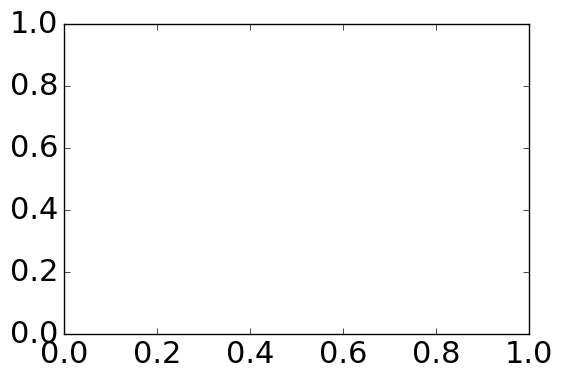

/home/john/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


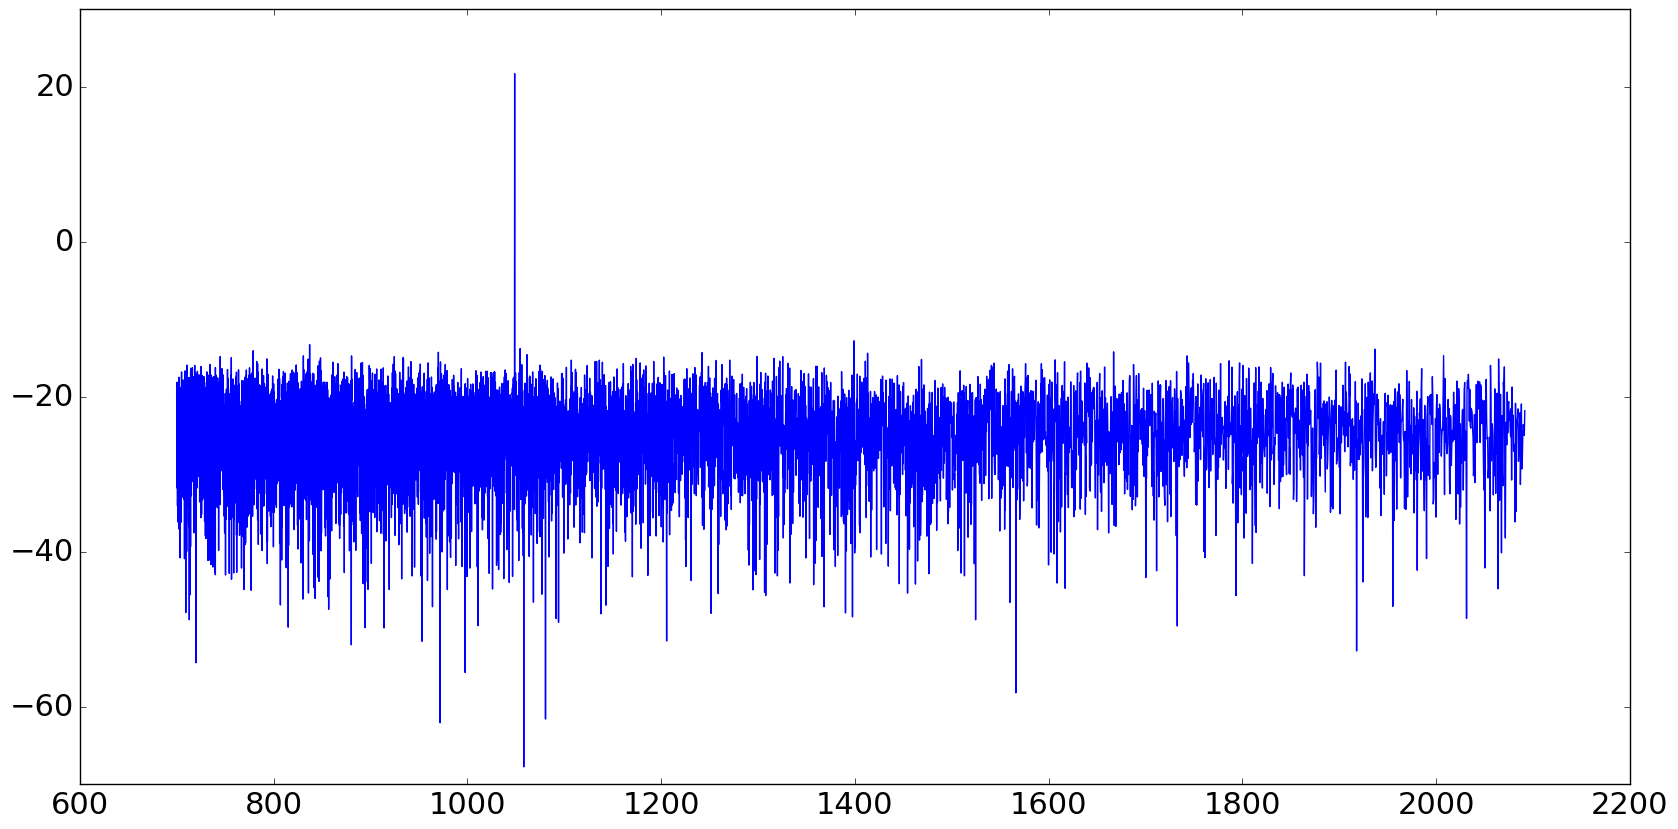

1048.885 837.23657516 4.1 [[  4.72034763e-05]]


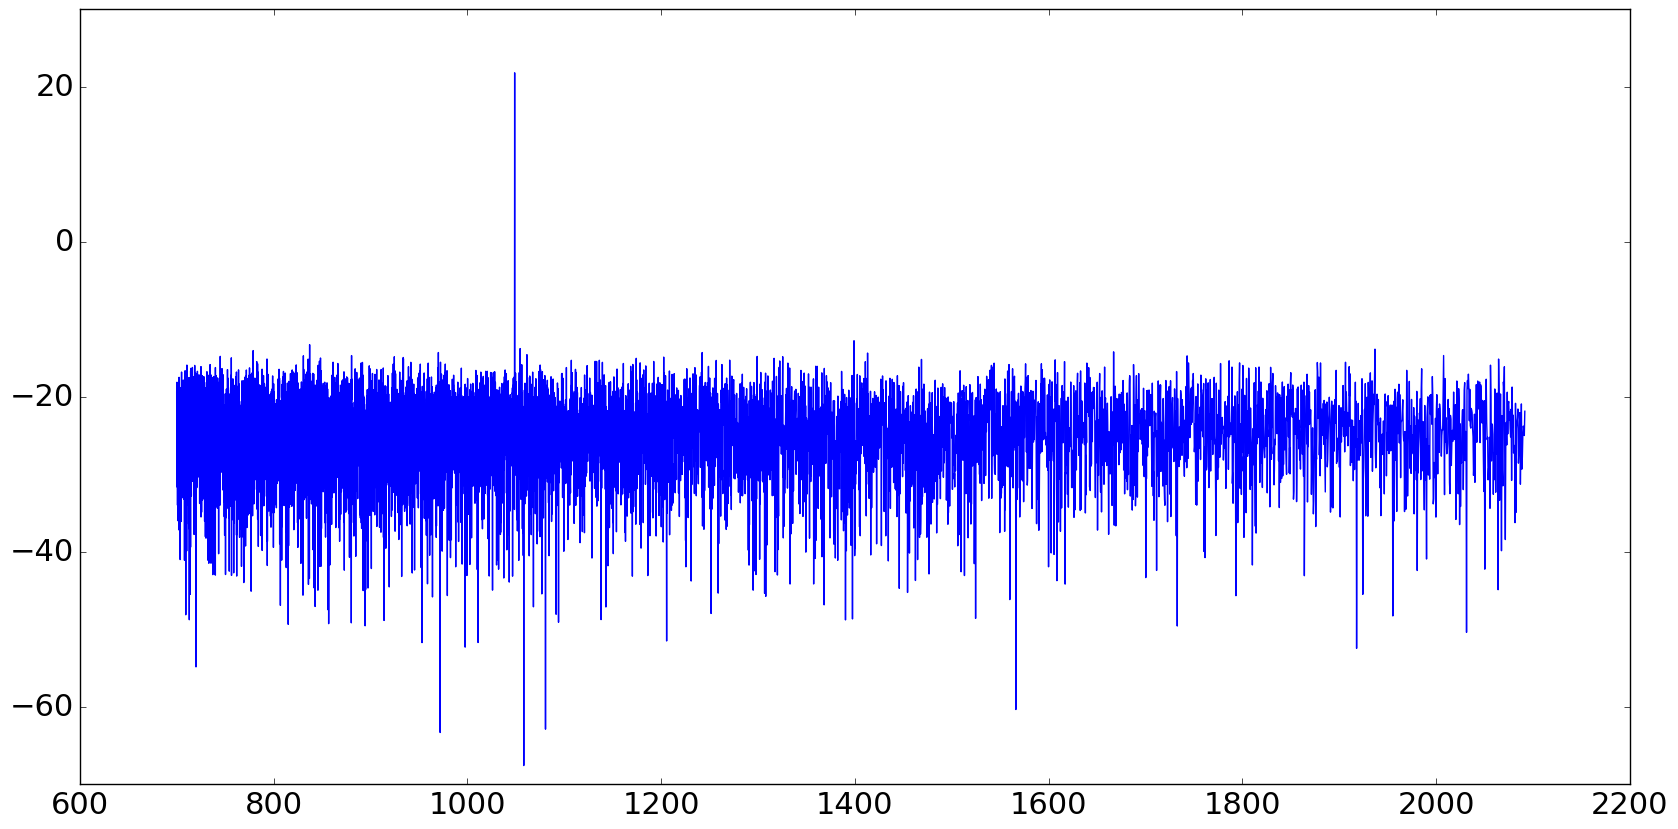

1048.885 837.23657516 4.2 [[  4.70302726e-05]]


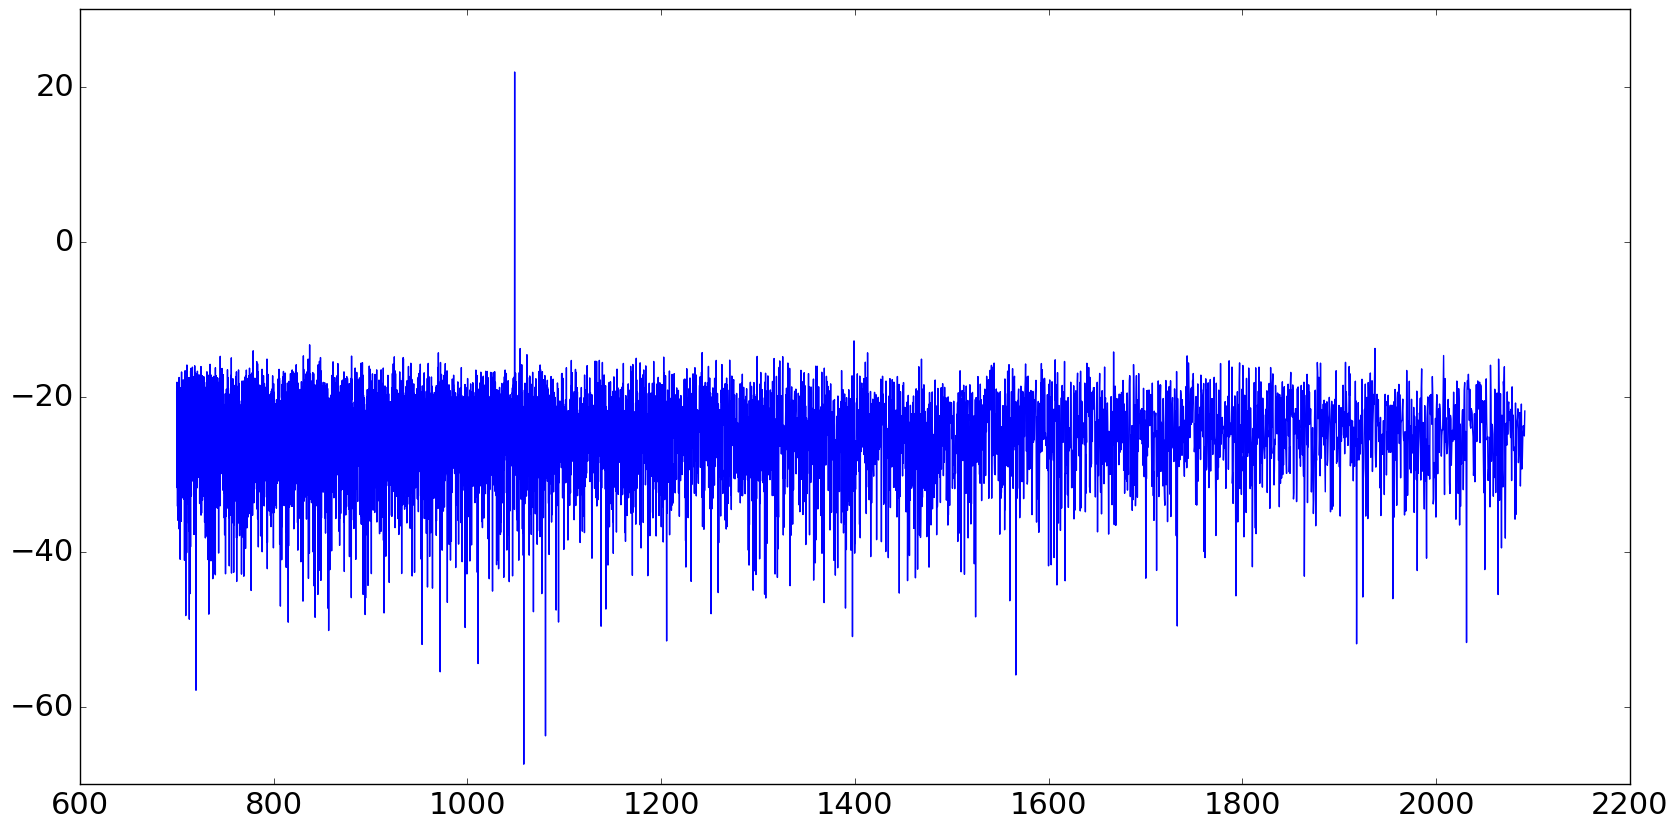

1048.885 837.23657516 4.3 [[  4.68272931e-05]]


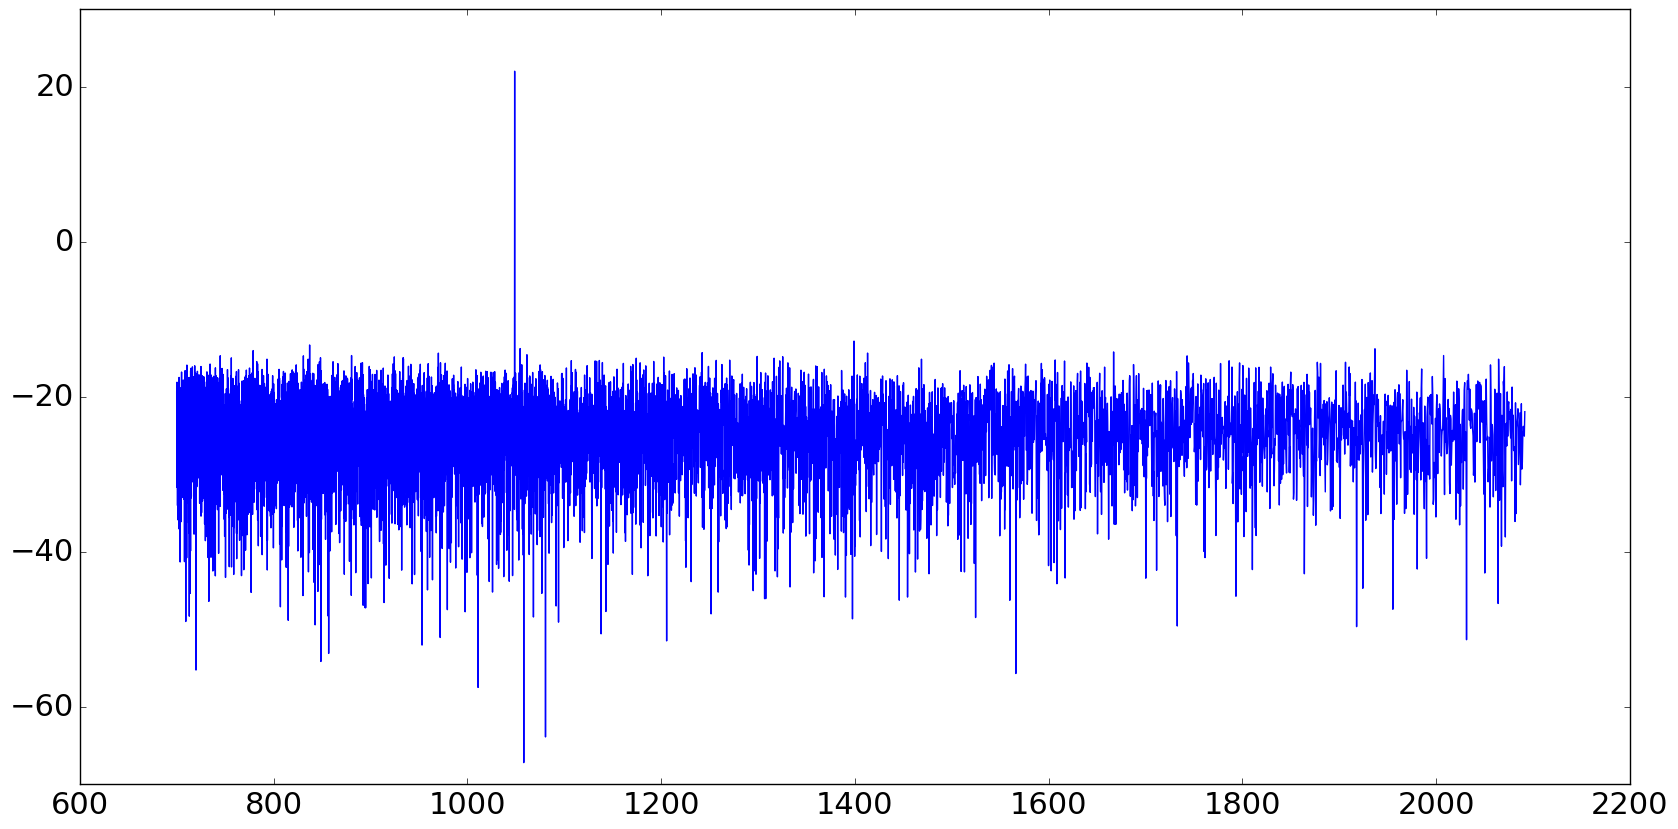

1048.885 837.23657516 4.4 [[  4.70644663e-05]]


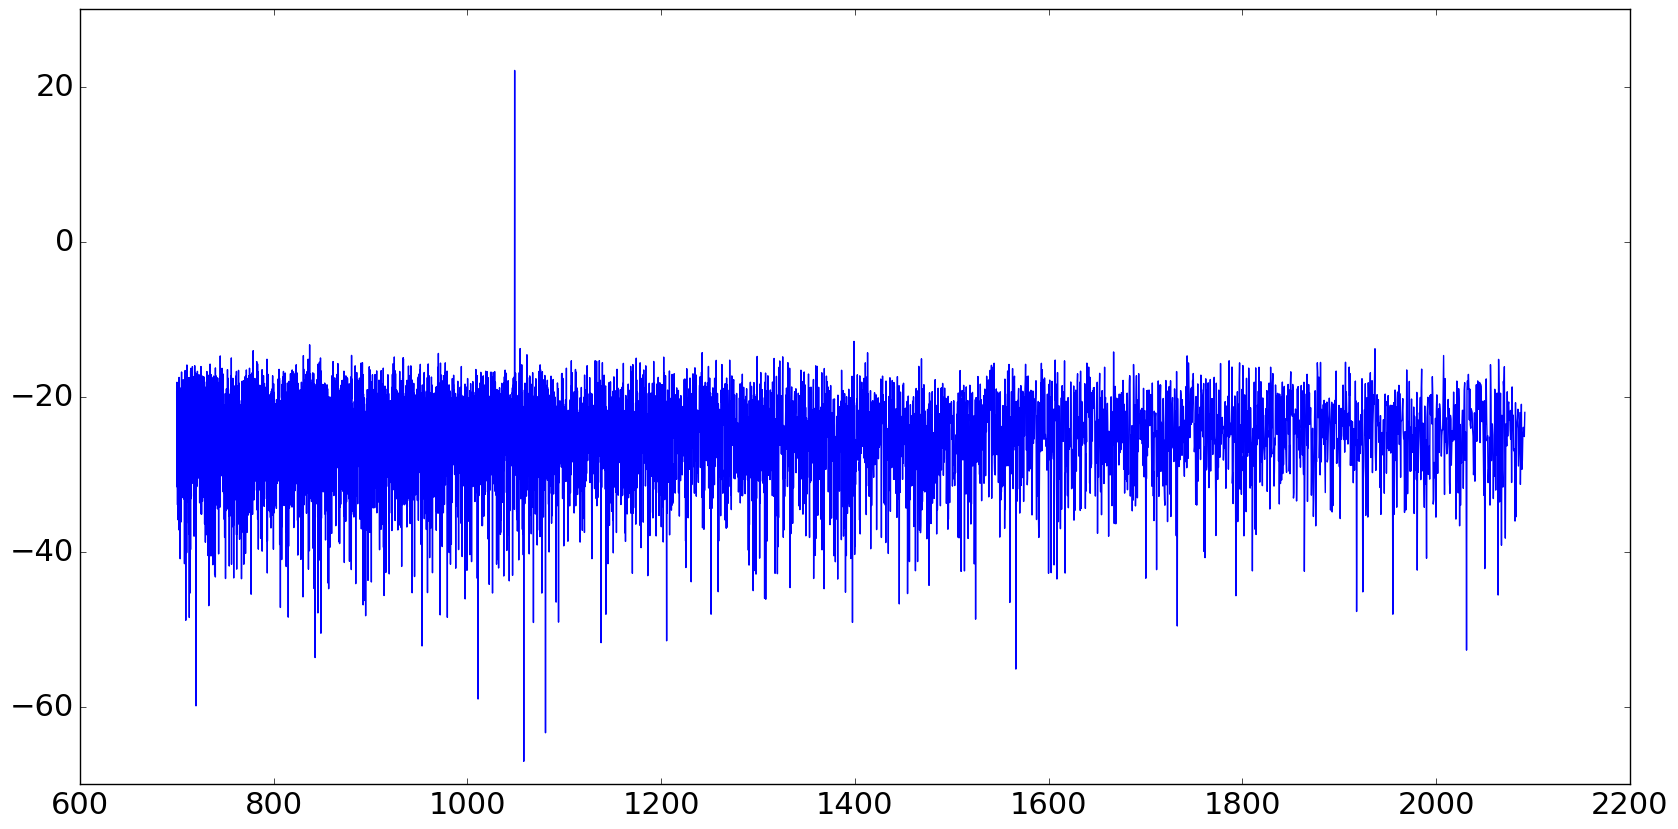

1048.885 837.23657516 4.5 [[  4.69504092e-05]]


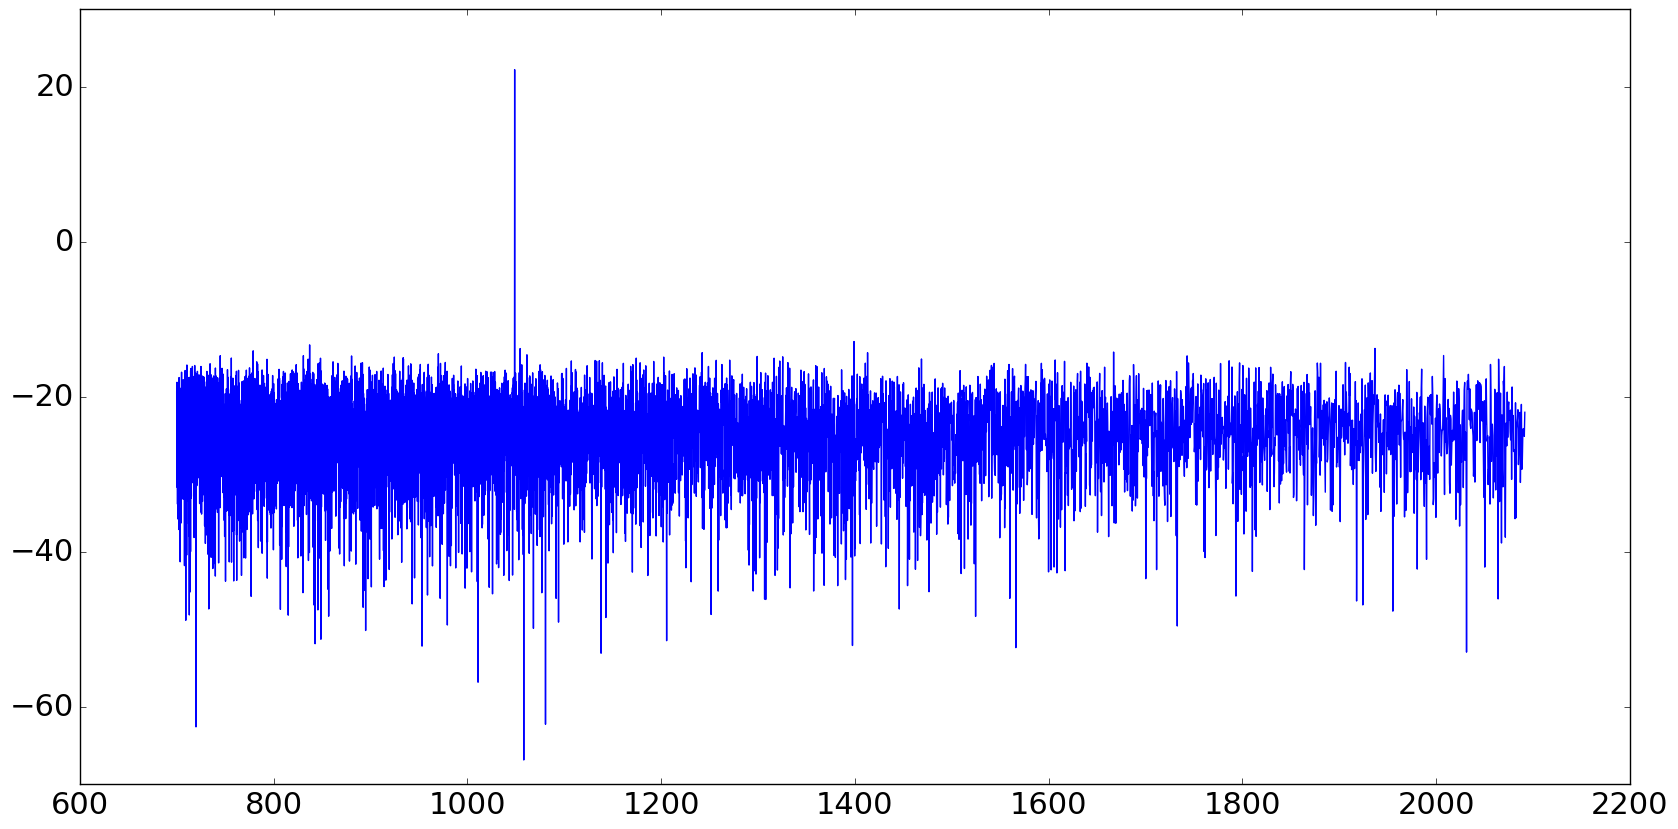

1048.885 867.143374205 4.6 [[  3.83914686e-05]]


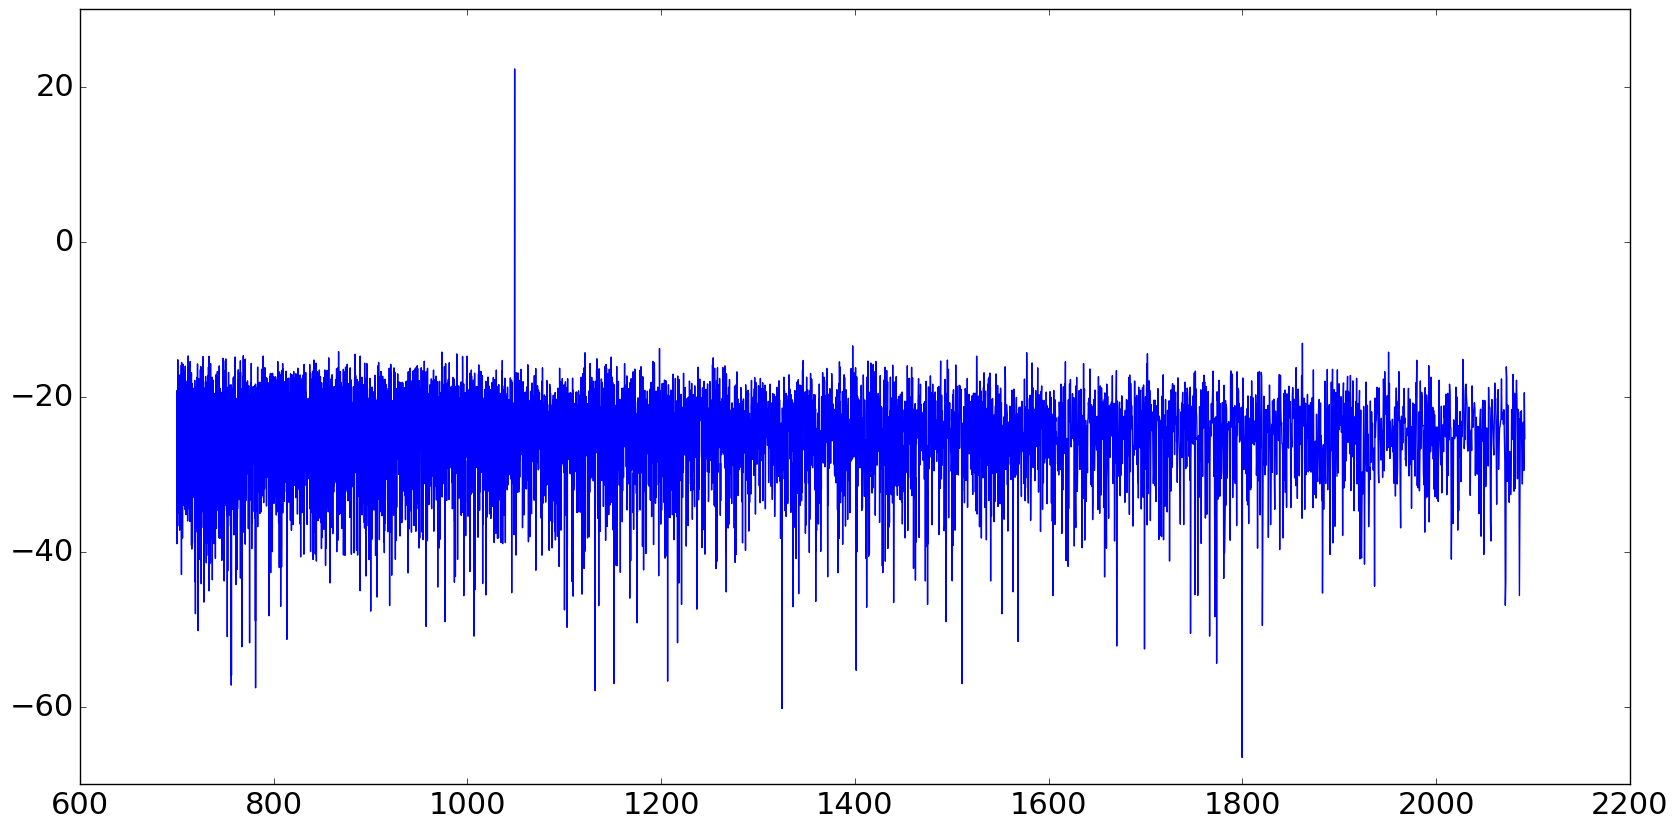

1048.885 973.746018423 4.7 [[  3.83859756e-05]]


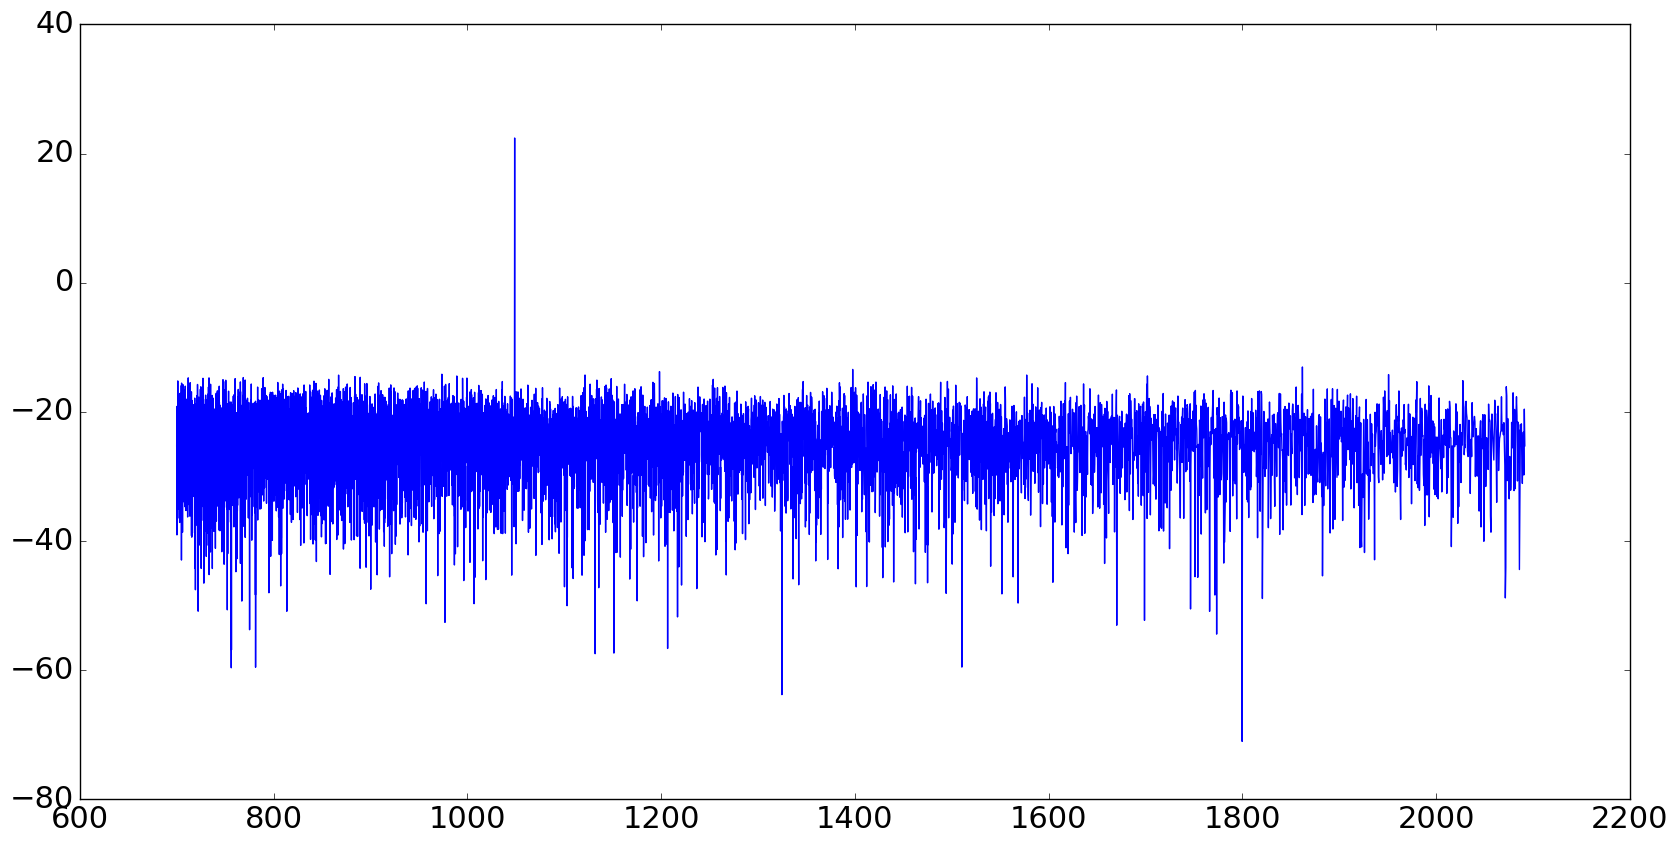

1048.885 973.746018423 4.8 [[  3.88856444e-05]]


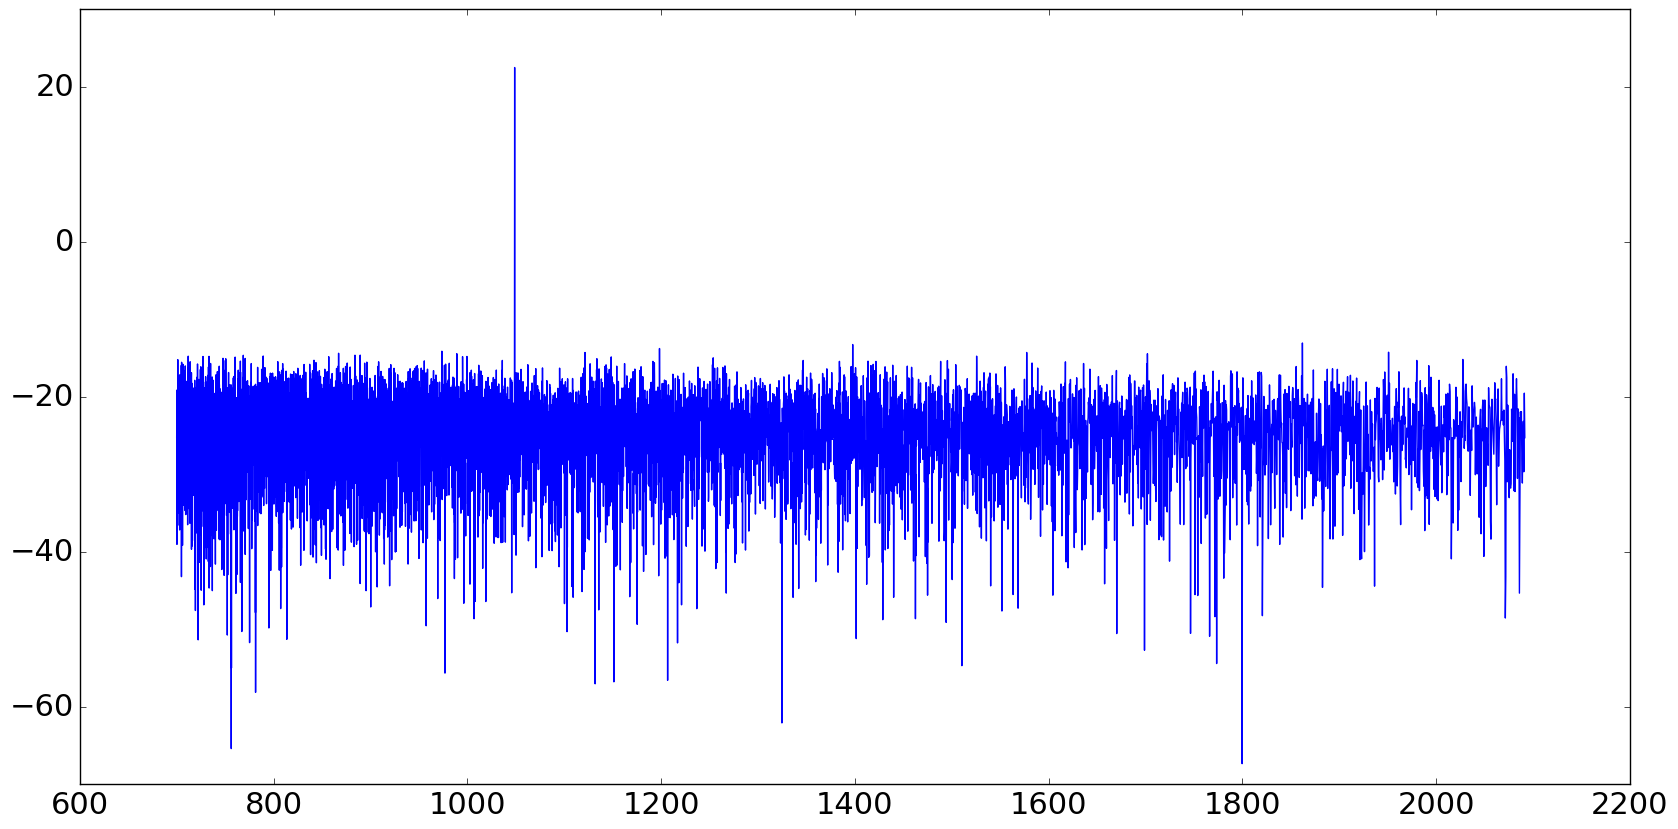

1048.885 973.746018423 4.9 [[  3.93804061e-05]]


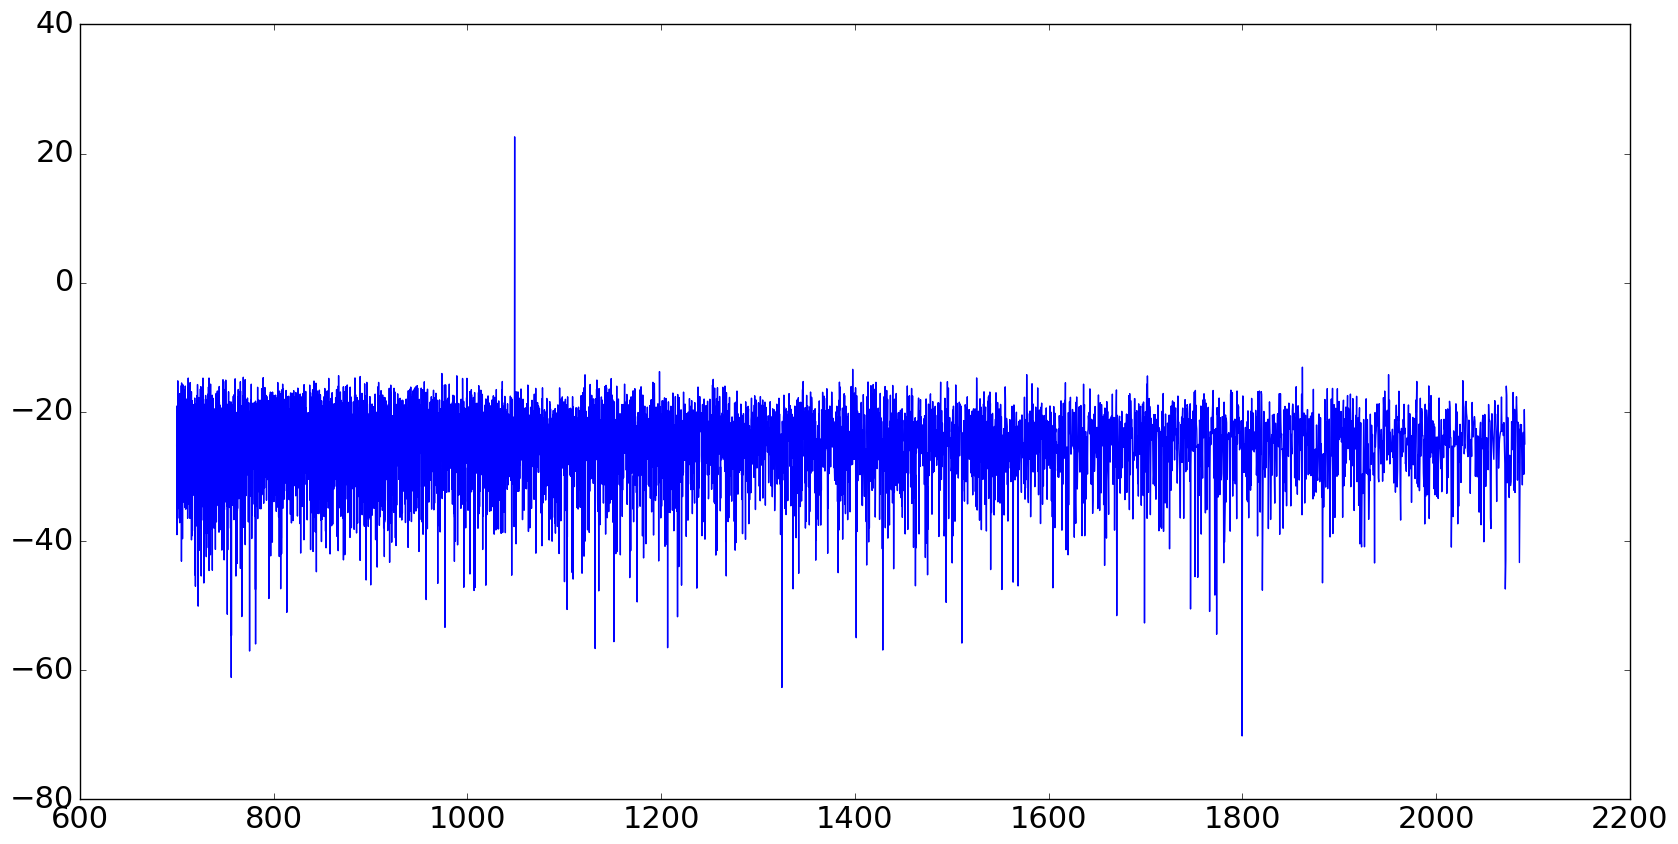

1048.885 973.746018423 5.0 [[  3.98579008e-05]]


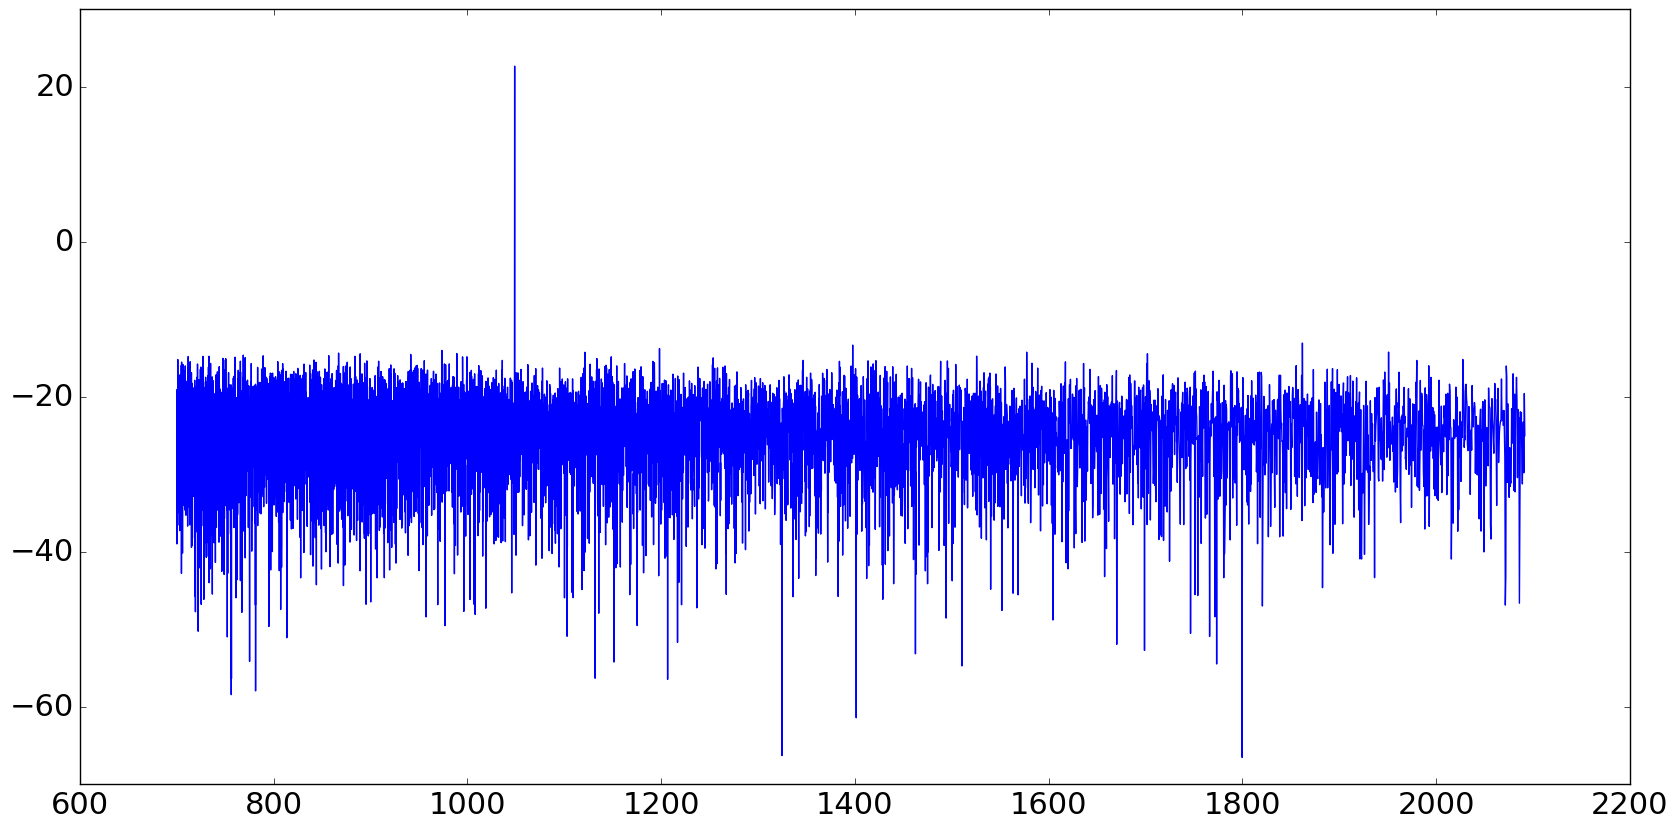

1048.885 941.614714405 5.1 [[  4.40028539e-05]]


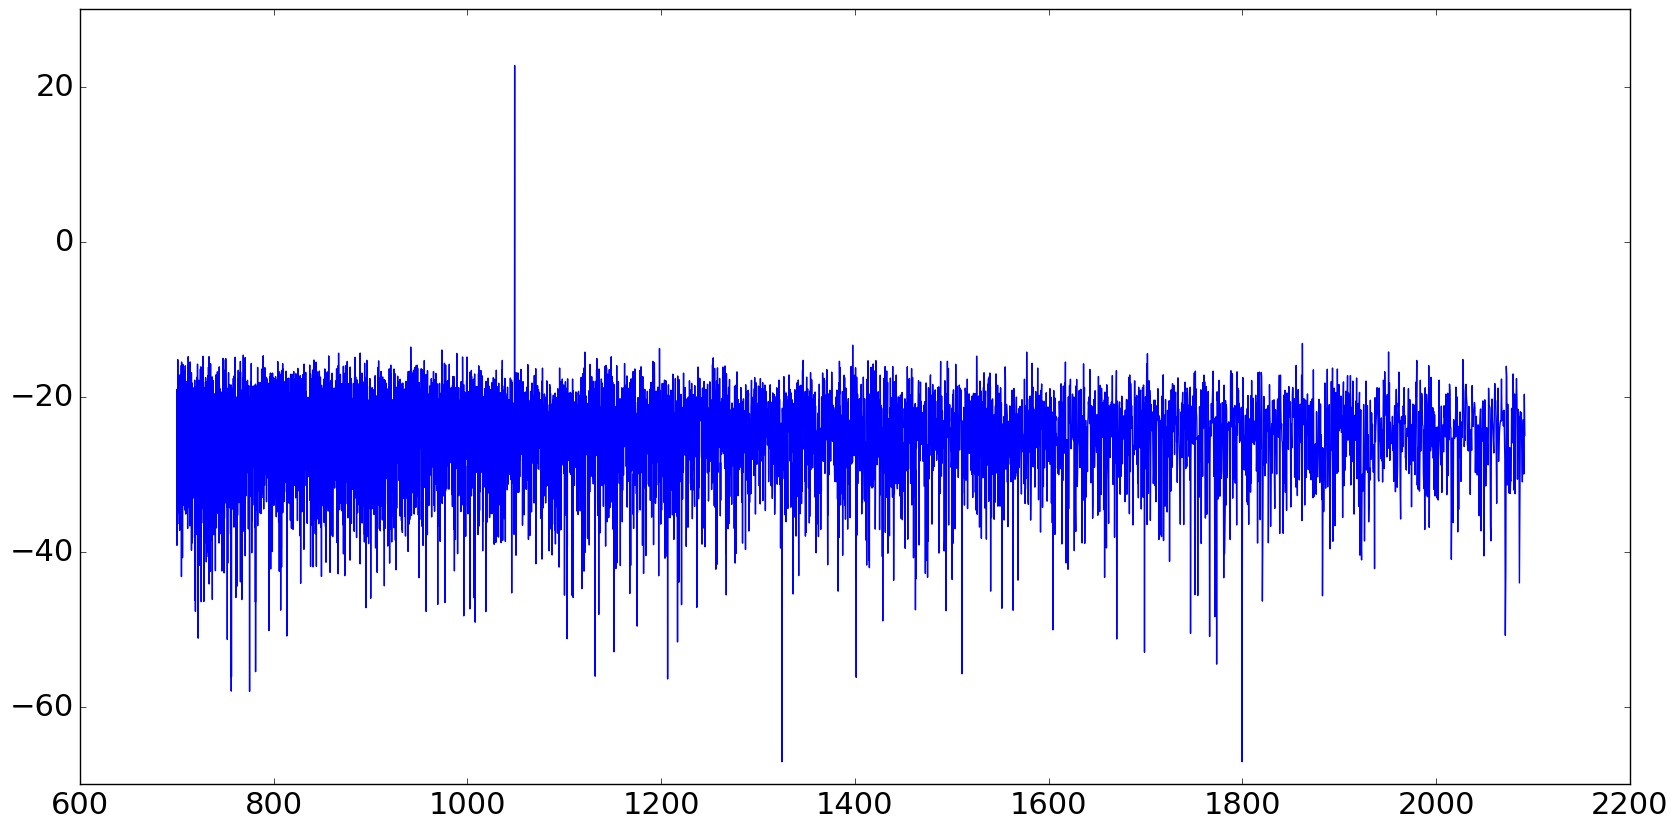

1048.885 941.614714405 5.2 [[  8.40214335e-05]]


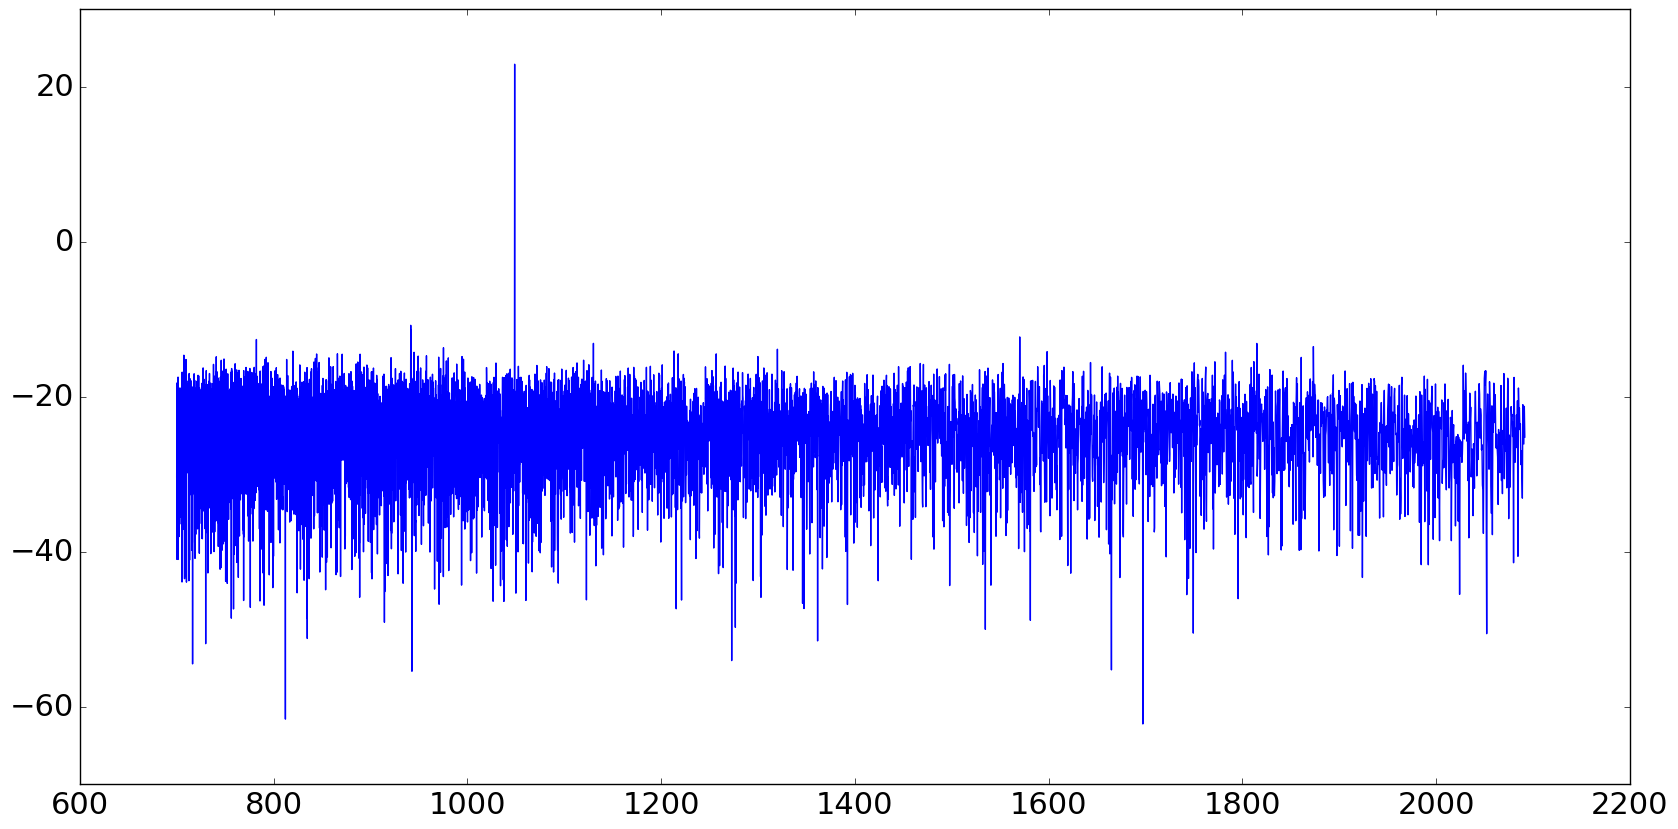

1048.885 941.820527906 5.3 [[ 0.00014573]]


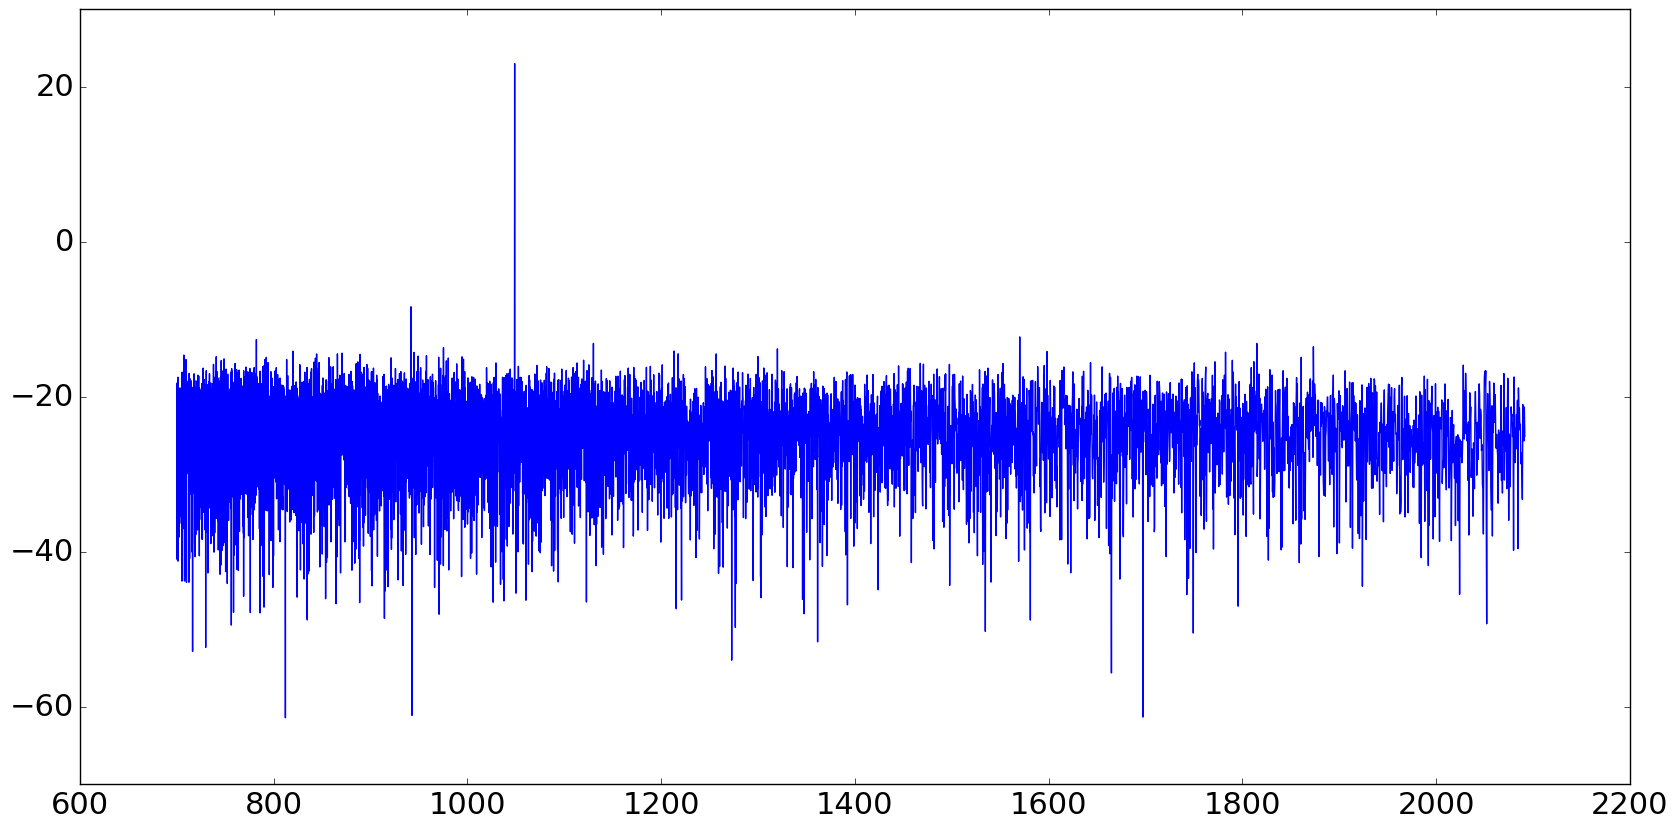

1048.885 941.820527906 5.4 [[ 0.00018875]]


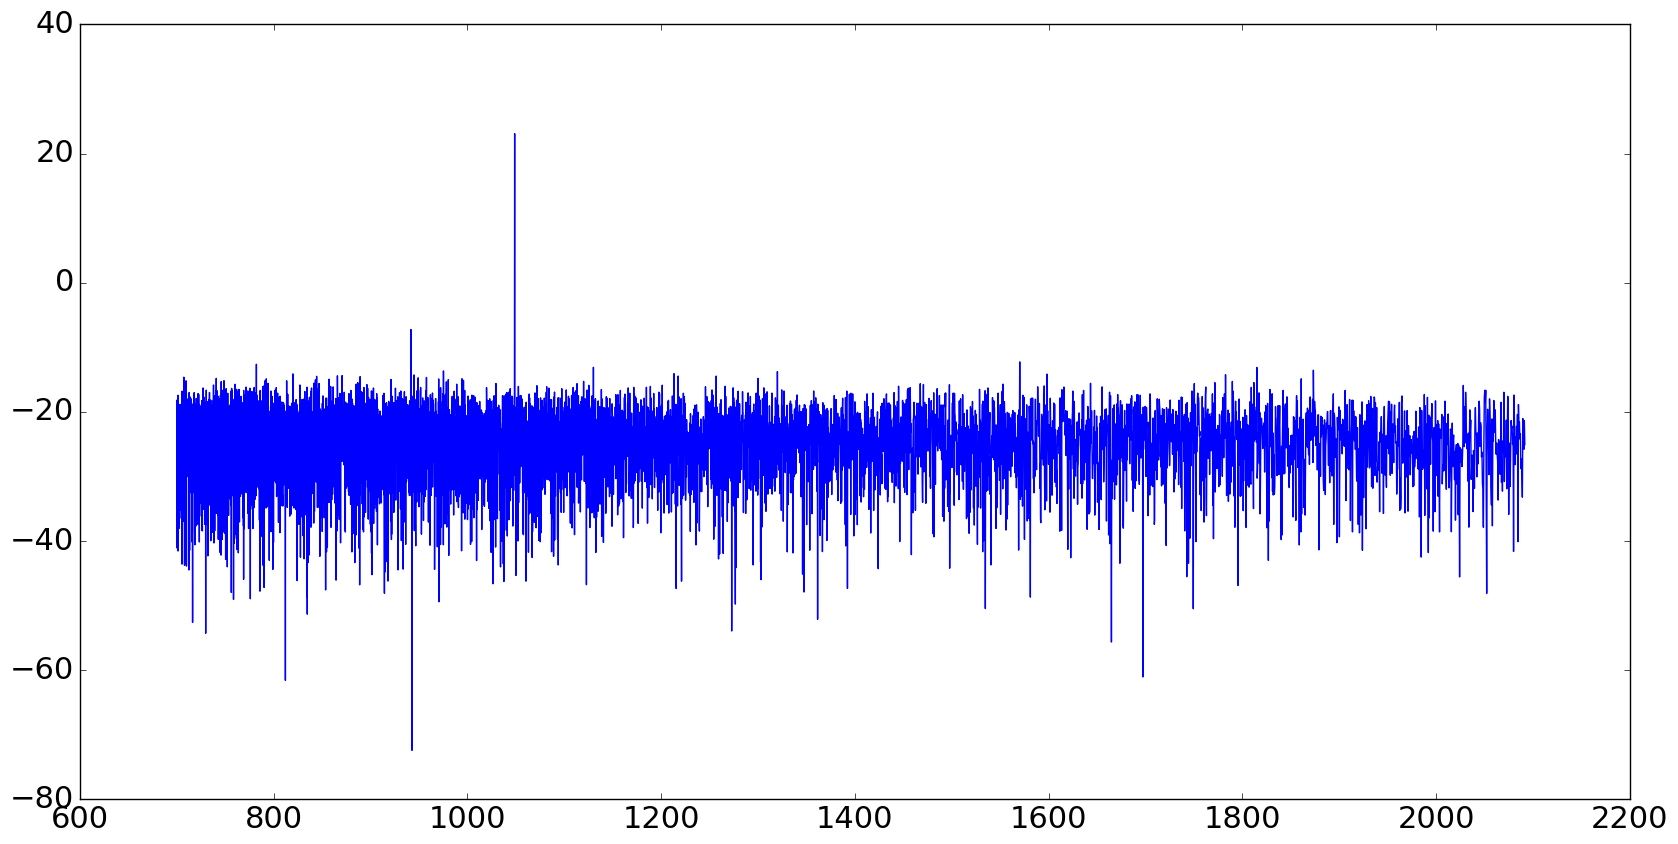

1048.885 941.820527906 5.5 [[ 0.00015562]]


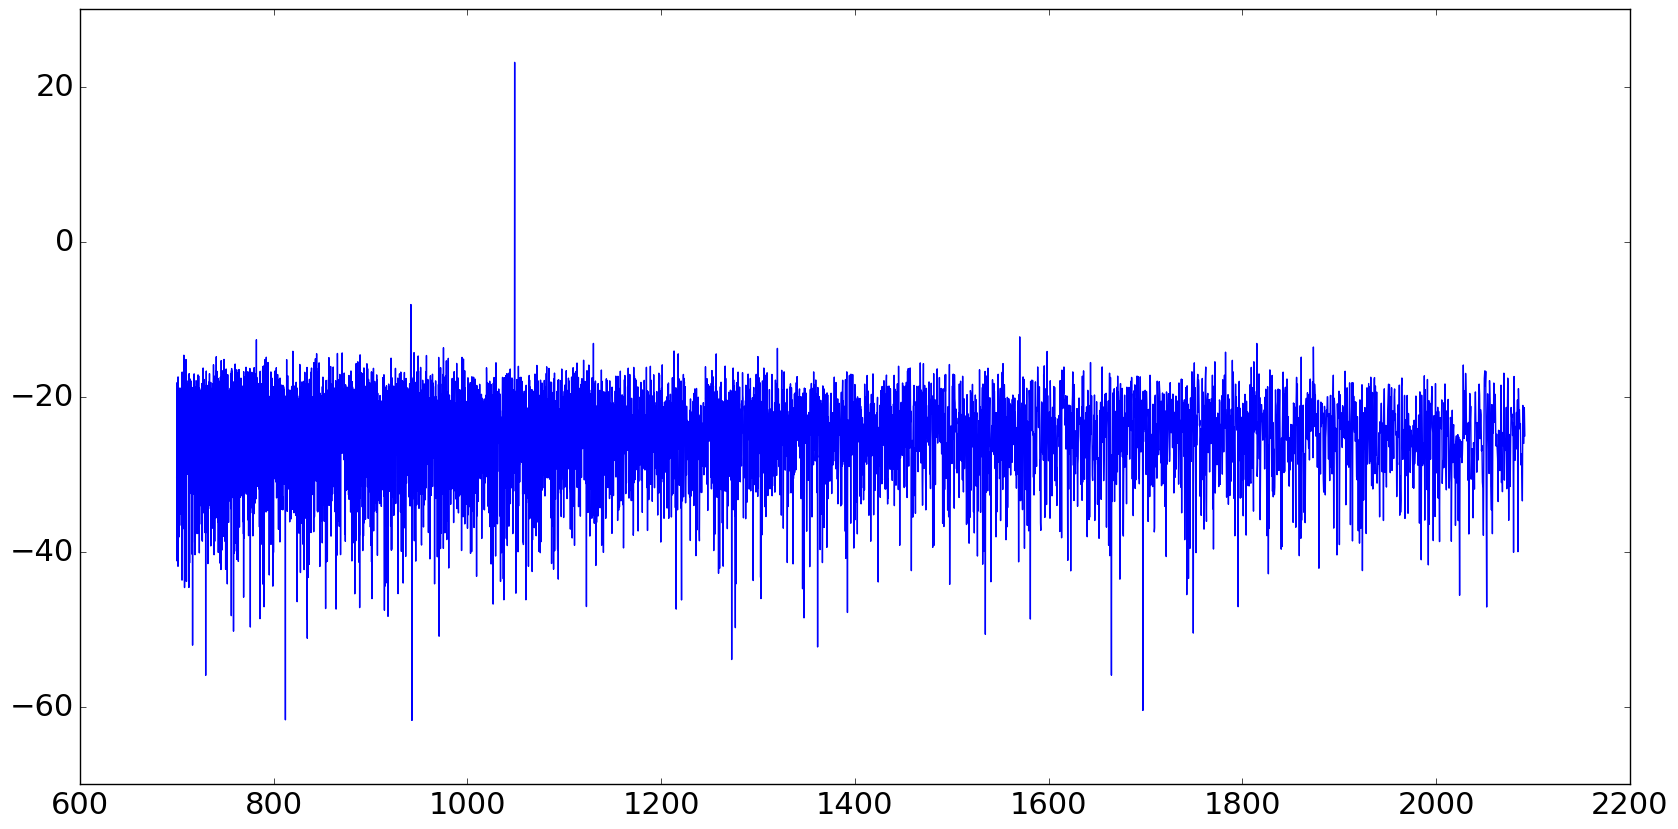

1048.885 941.614714405 5.6 [[ 0.00019282]]


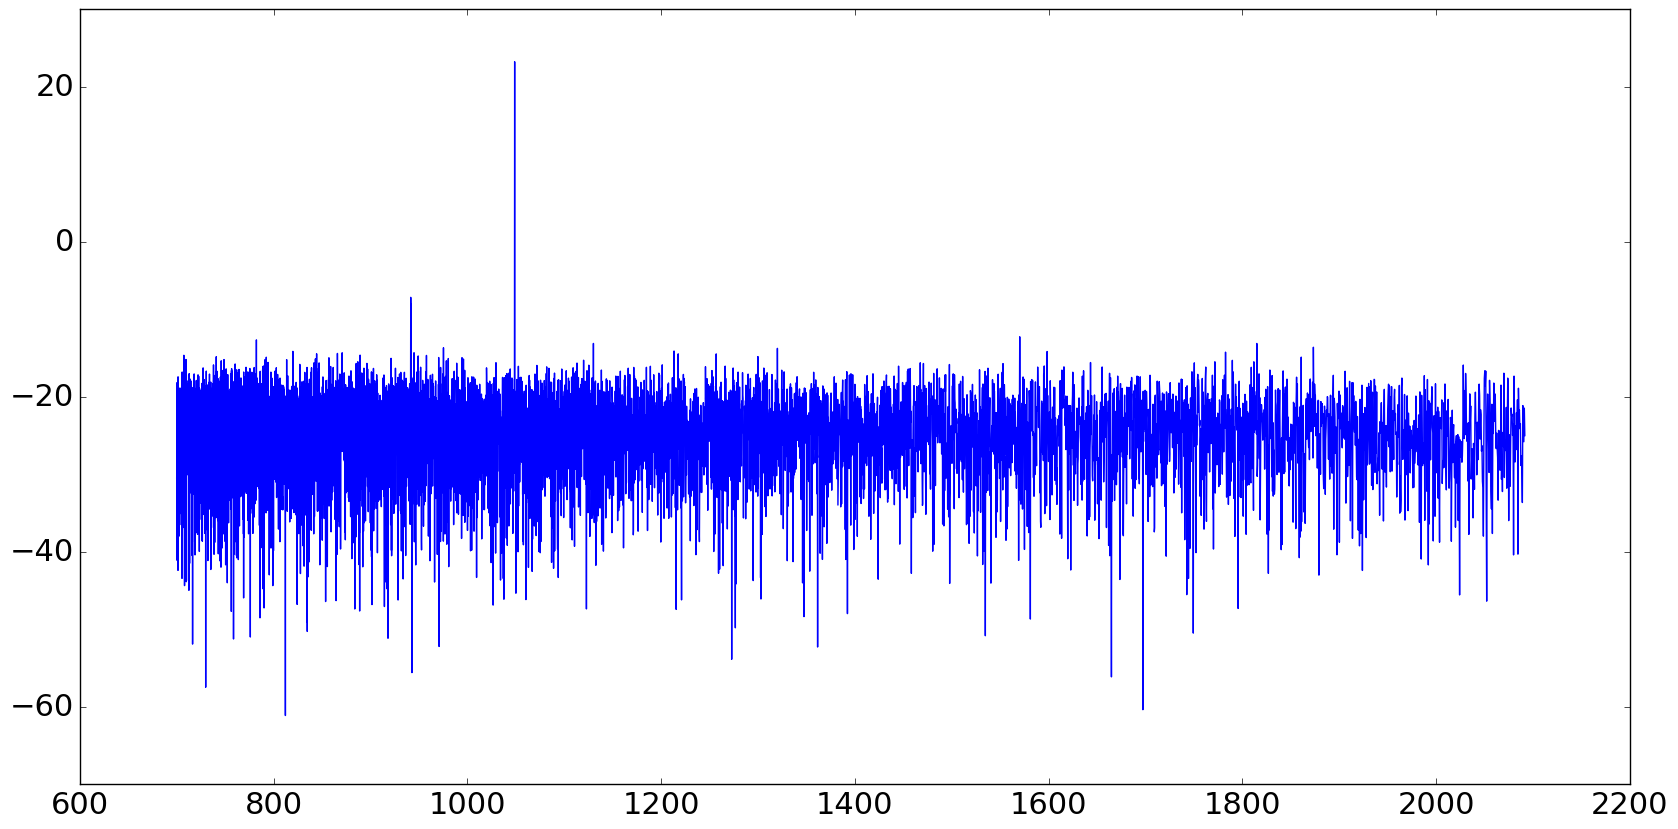

1048.885 941.614714405 5.7 [[ 0.00047059]]


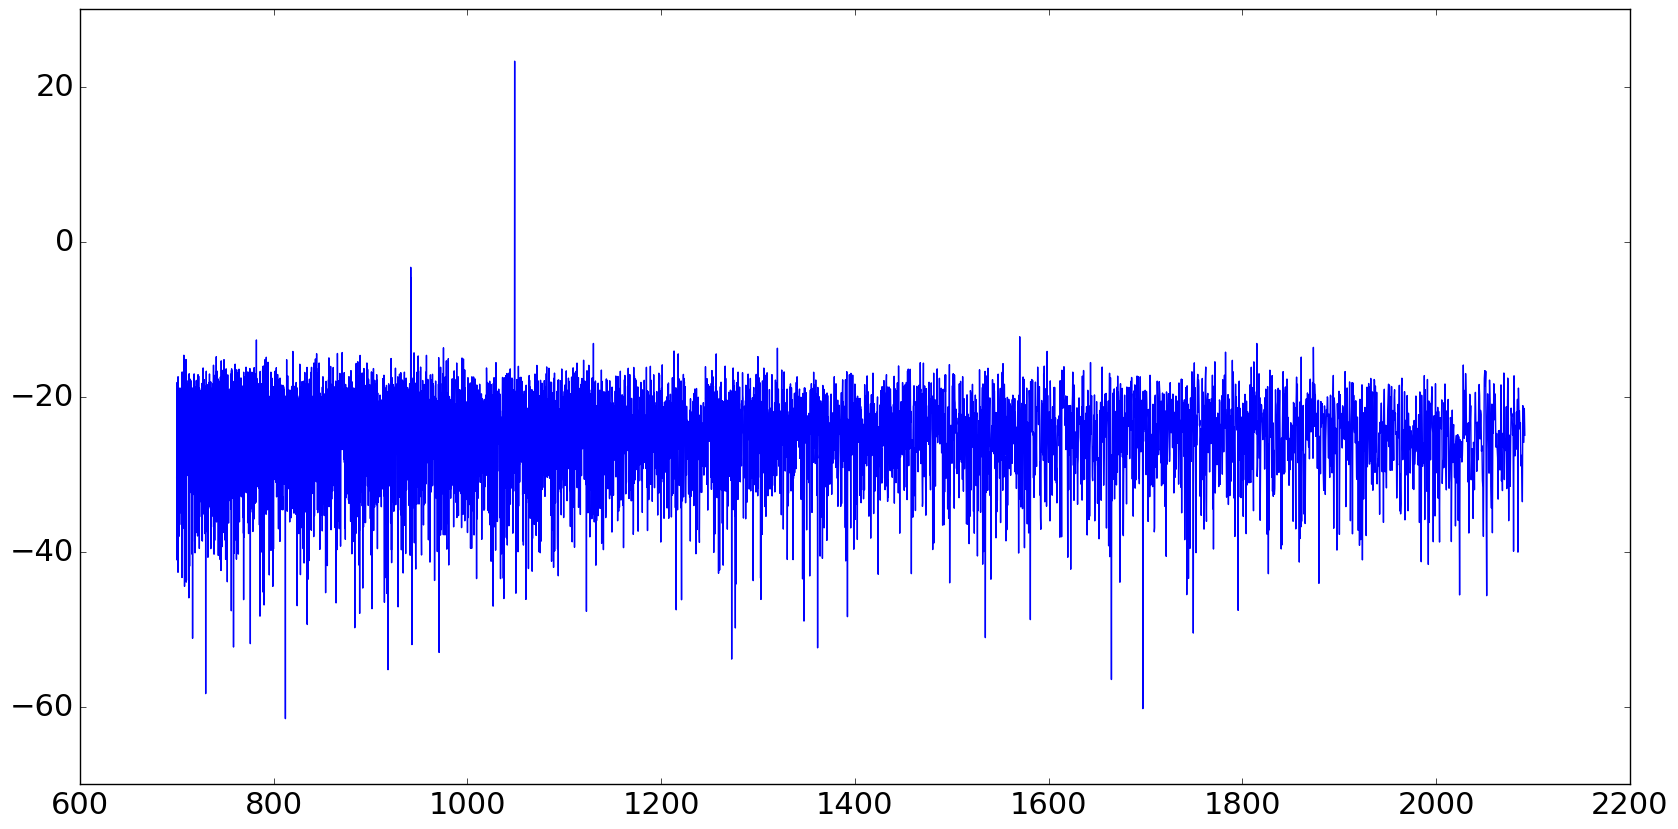

1048.885 941.71760991 5.8 [[ 0.00328356]]


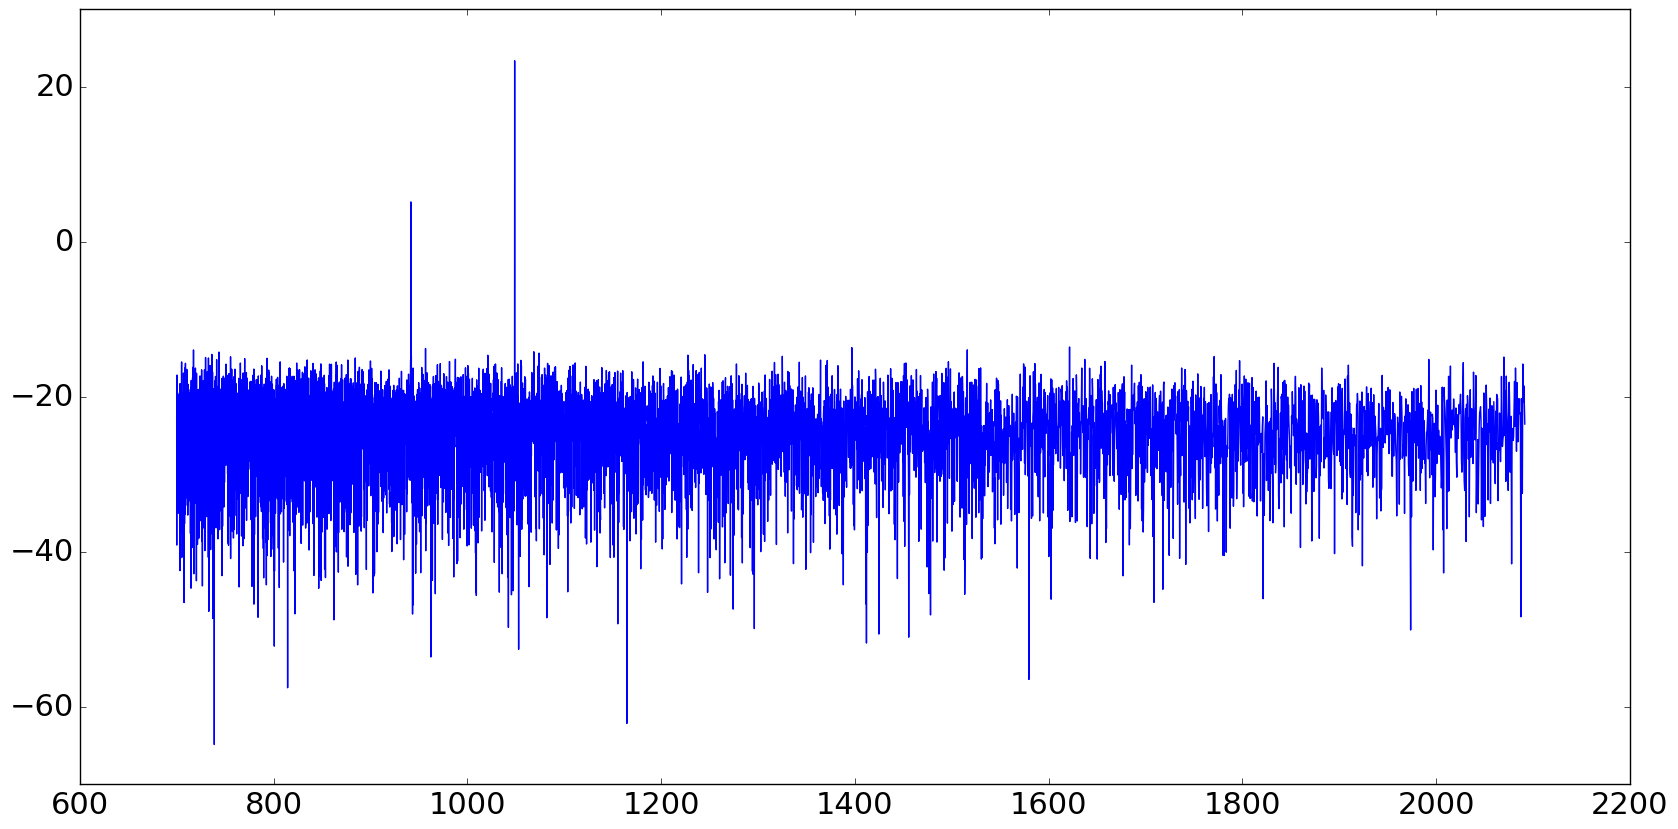

1048.885 941.820527906 5.9 [[ 0.00858239]]


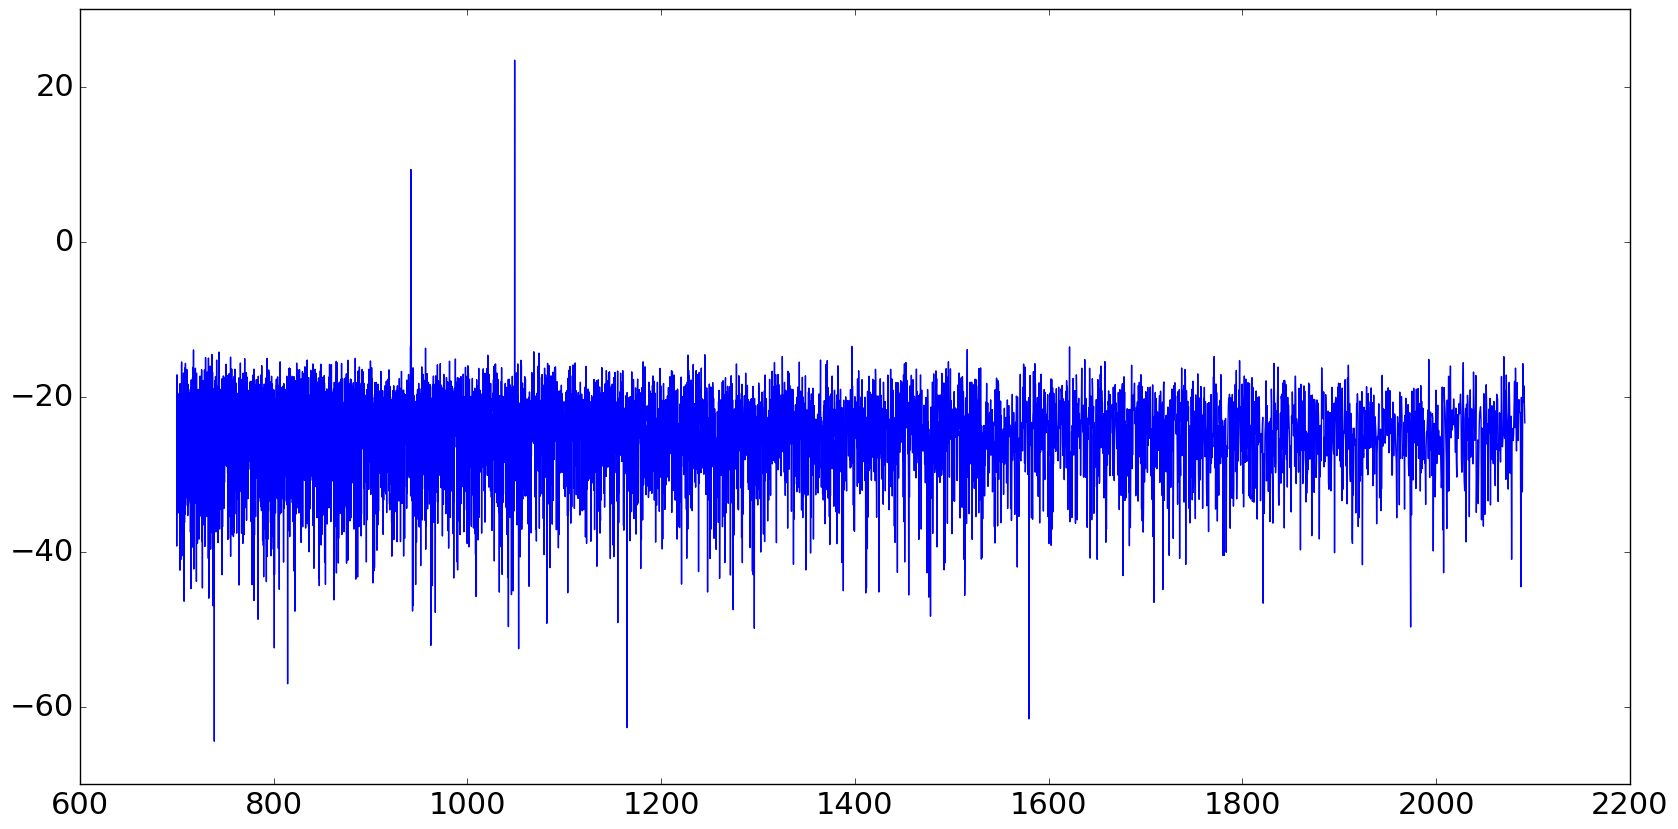

1048.885 941.820527906 6.0 [[ 0.02575917]]


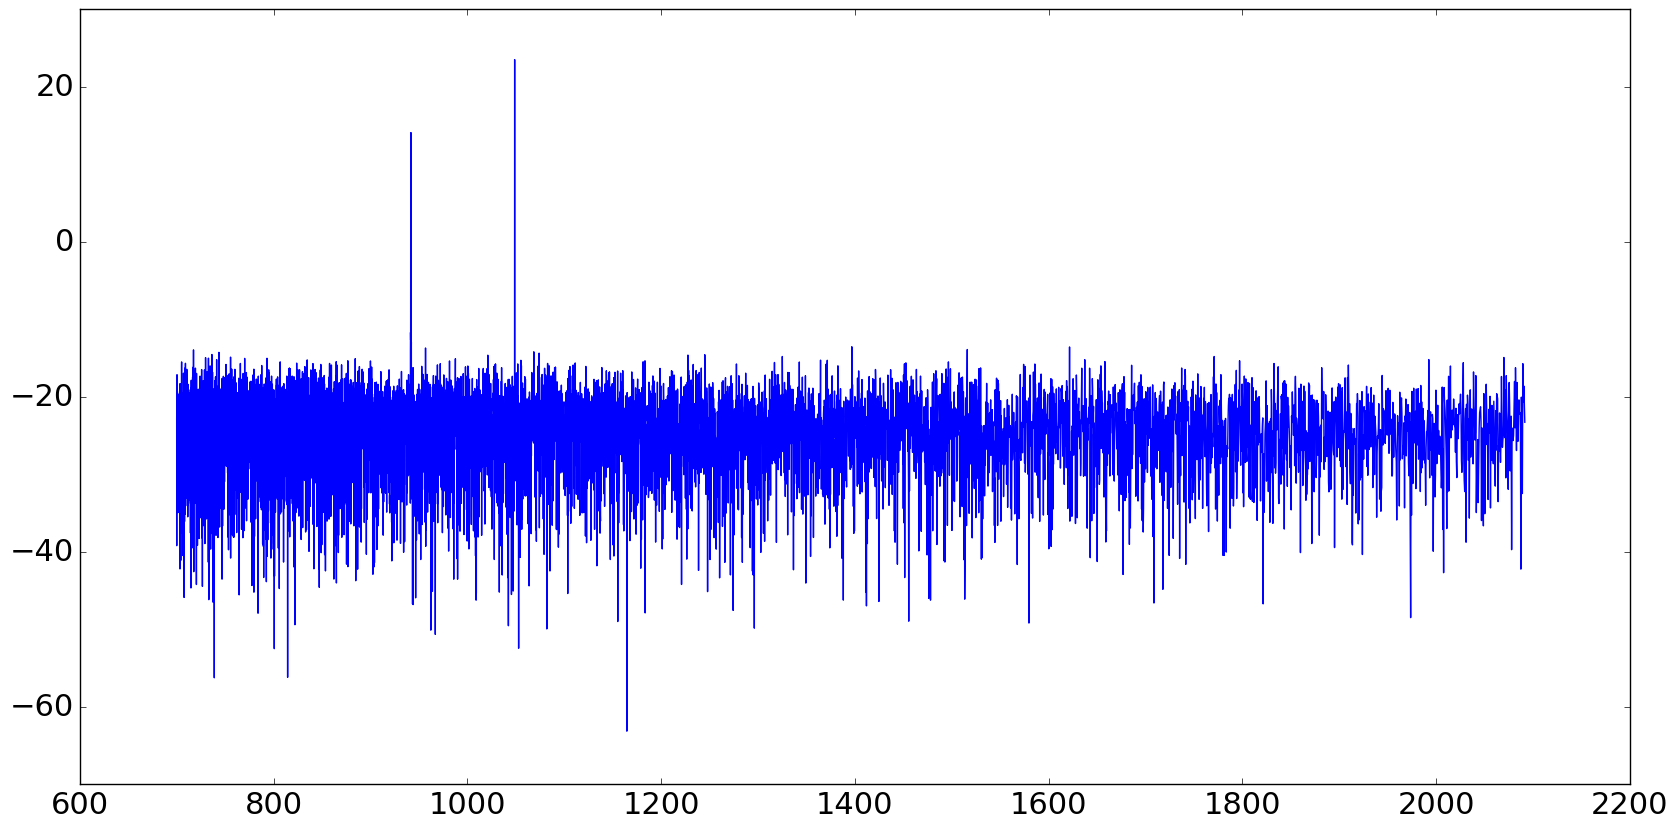

1048.885 941.614714405 6.1 [[ 0.09061043]]


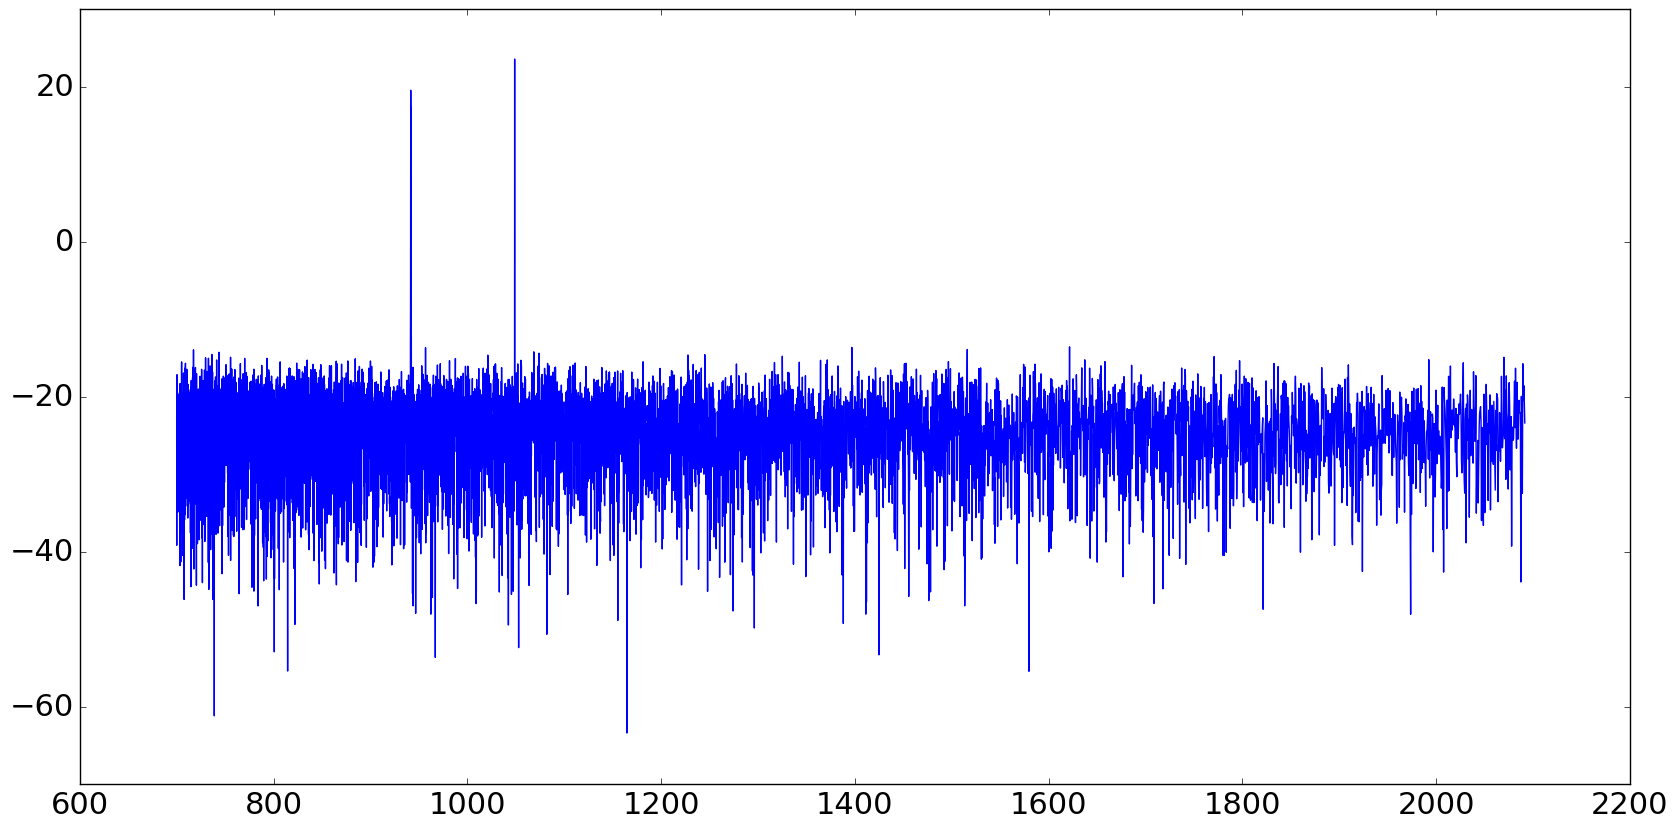

1048.885 941.614714405 6.2 [[ 0.27069064]]


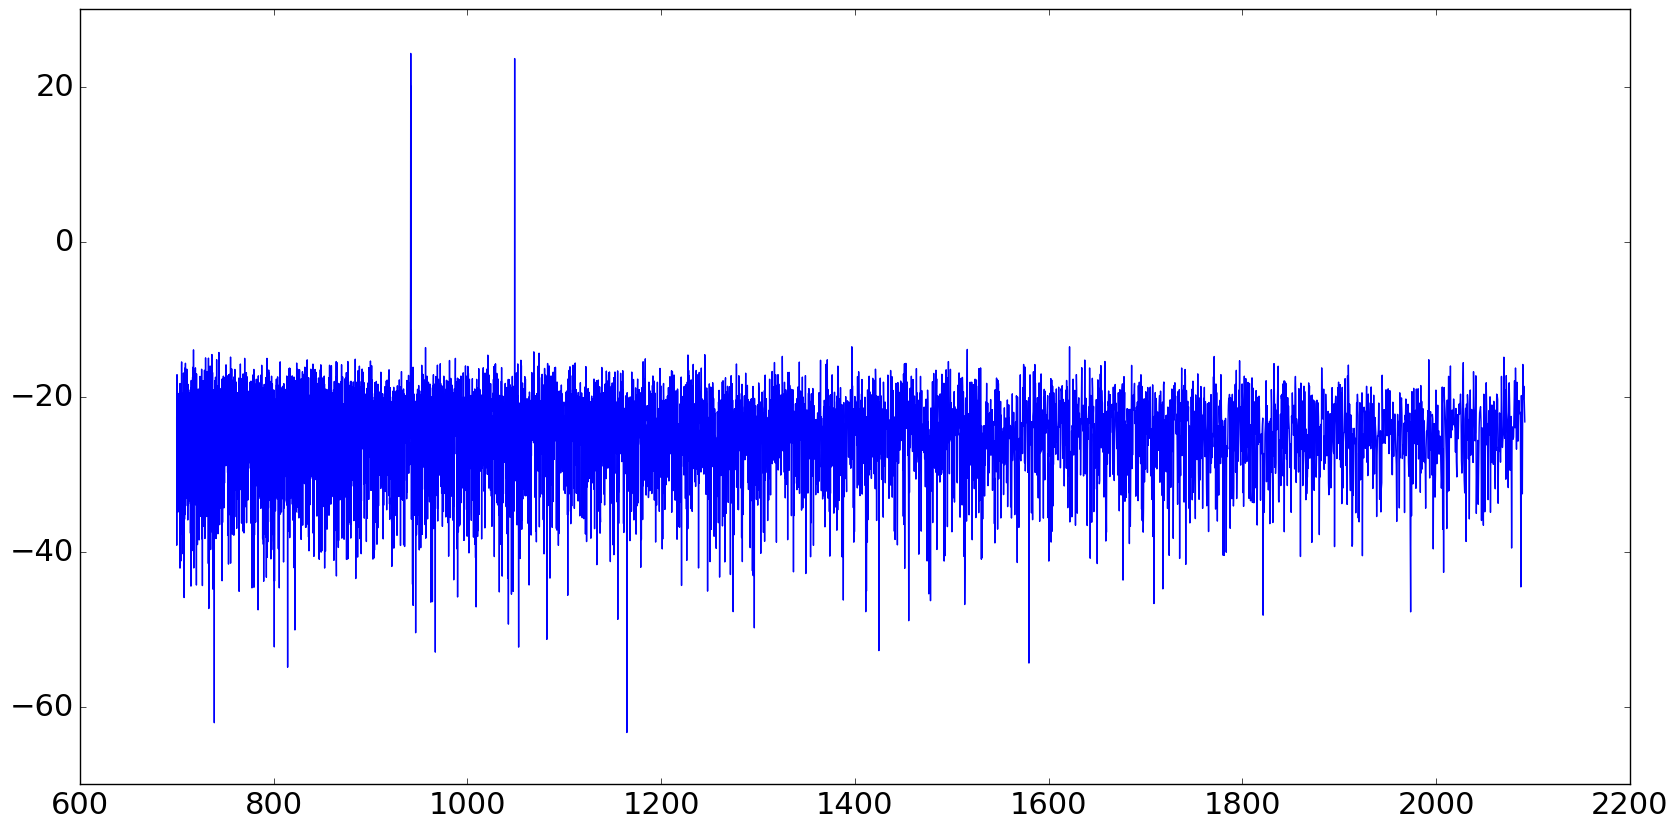

1048.885 941.614714405 6.3 [[ 0.77812147]]


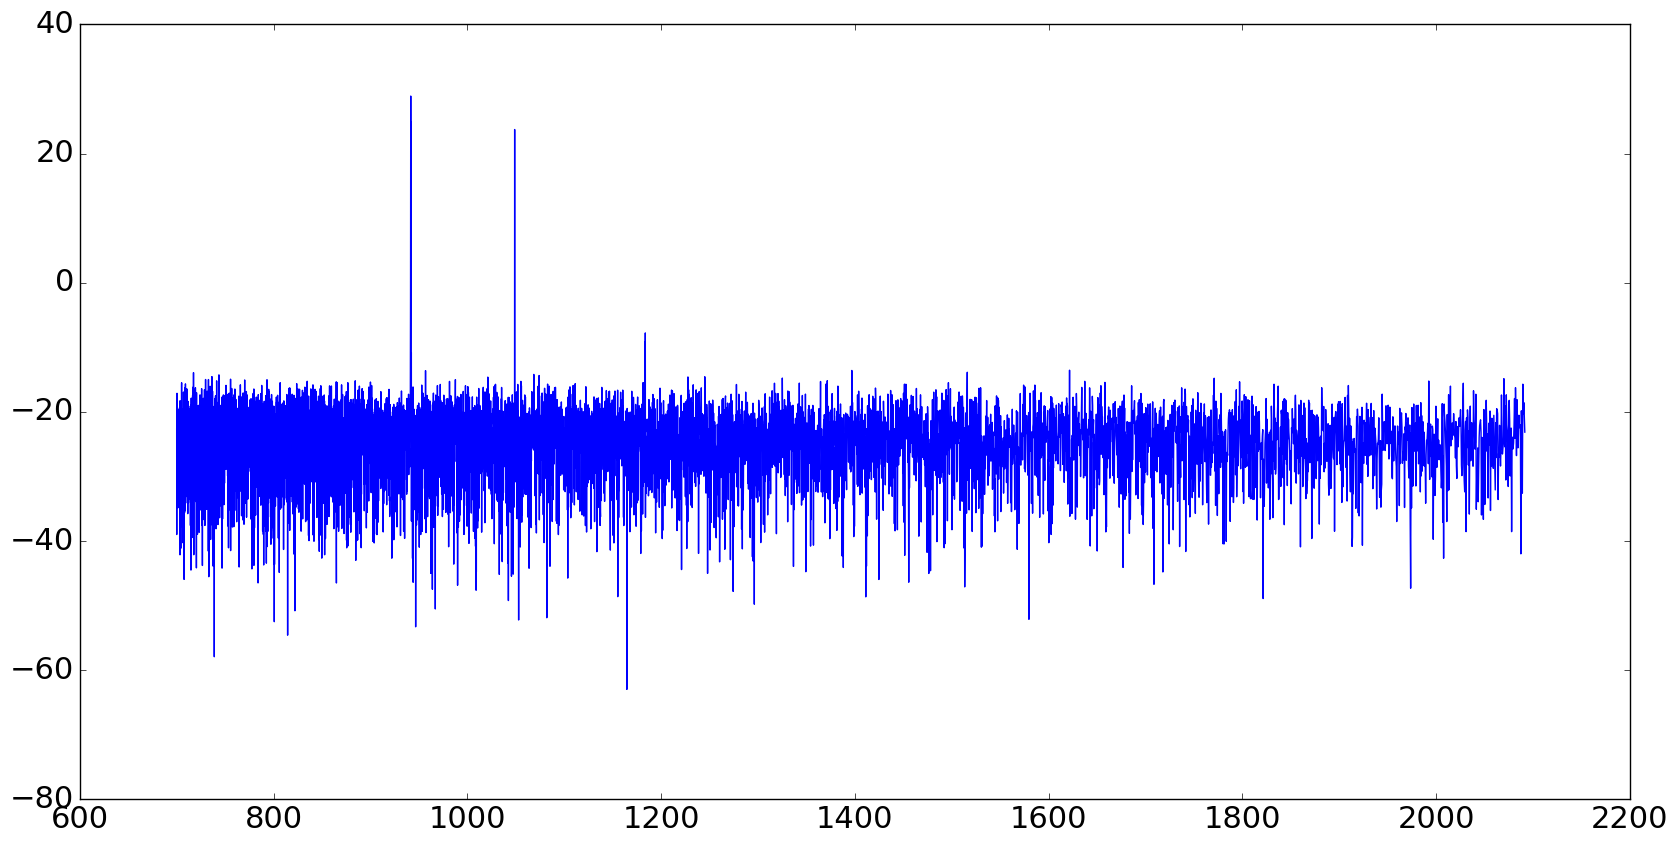

1048.885 941.71760991 6.4 [[ 7.88490655]]


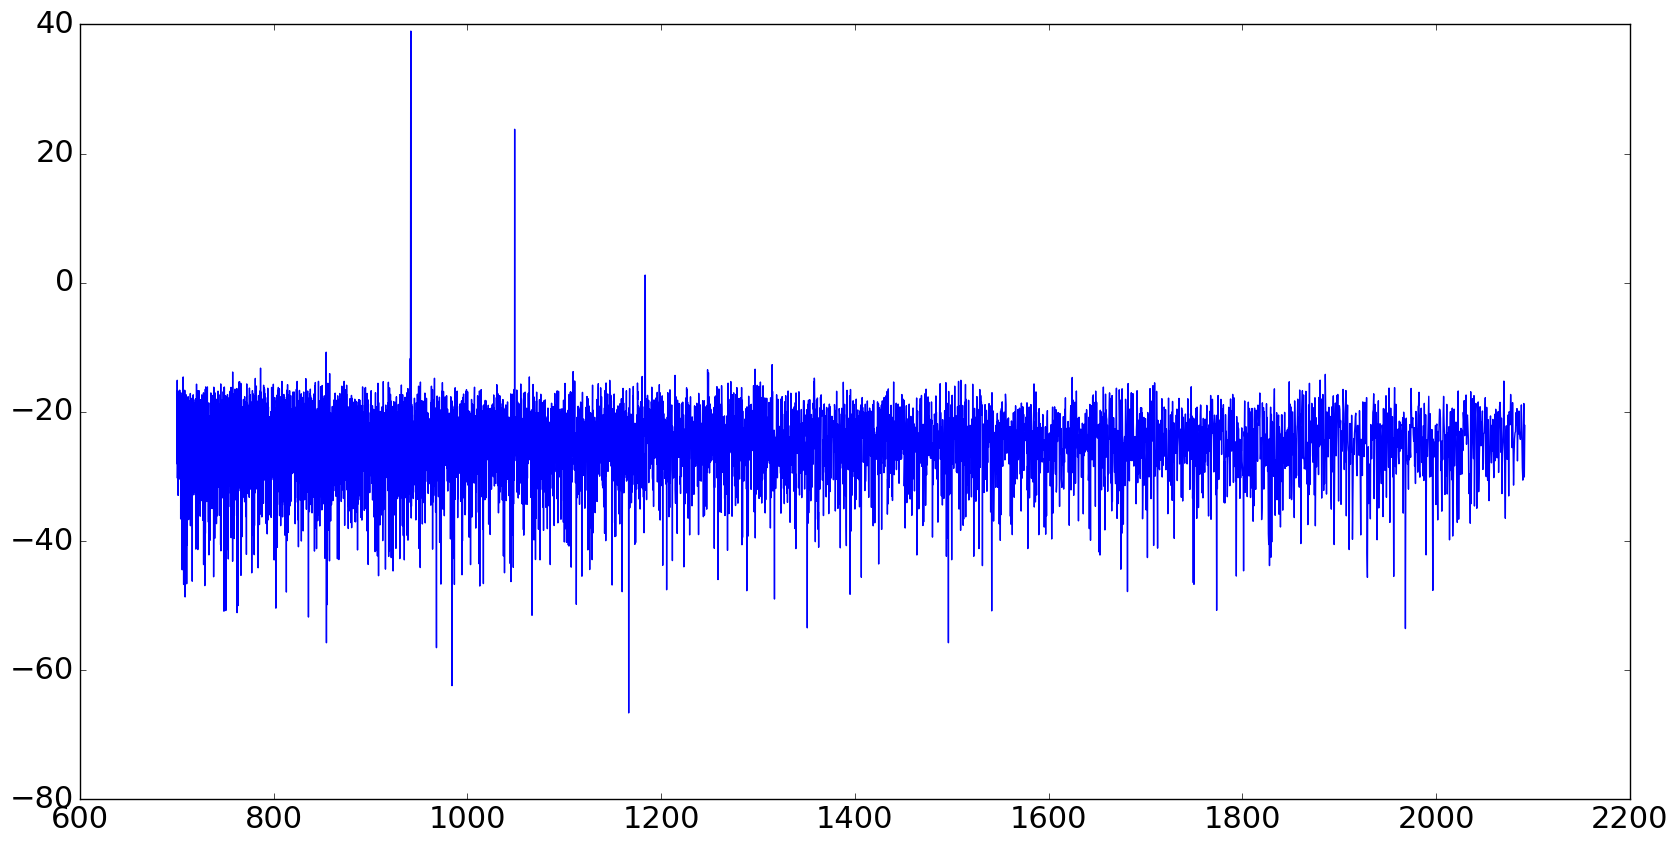

1048.885 941.71760991 6.5 [[ 39.07551851]]


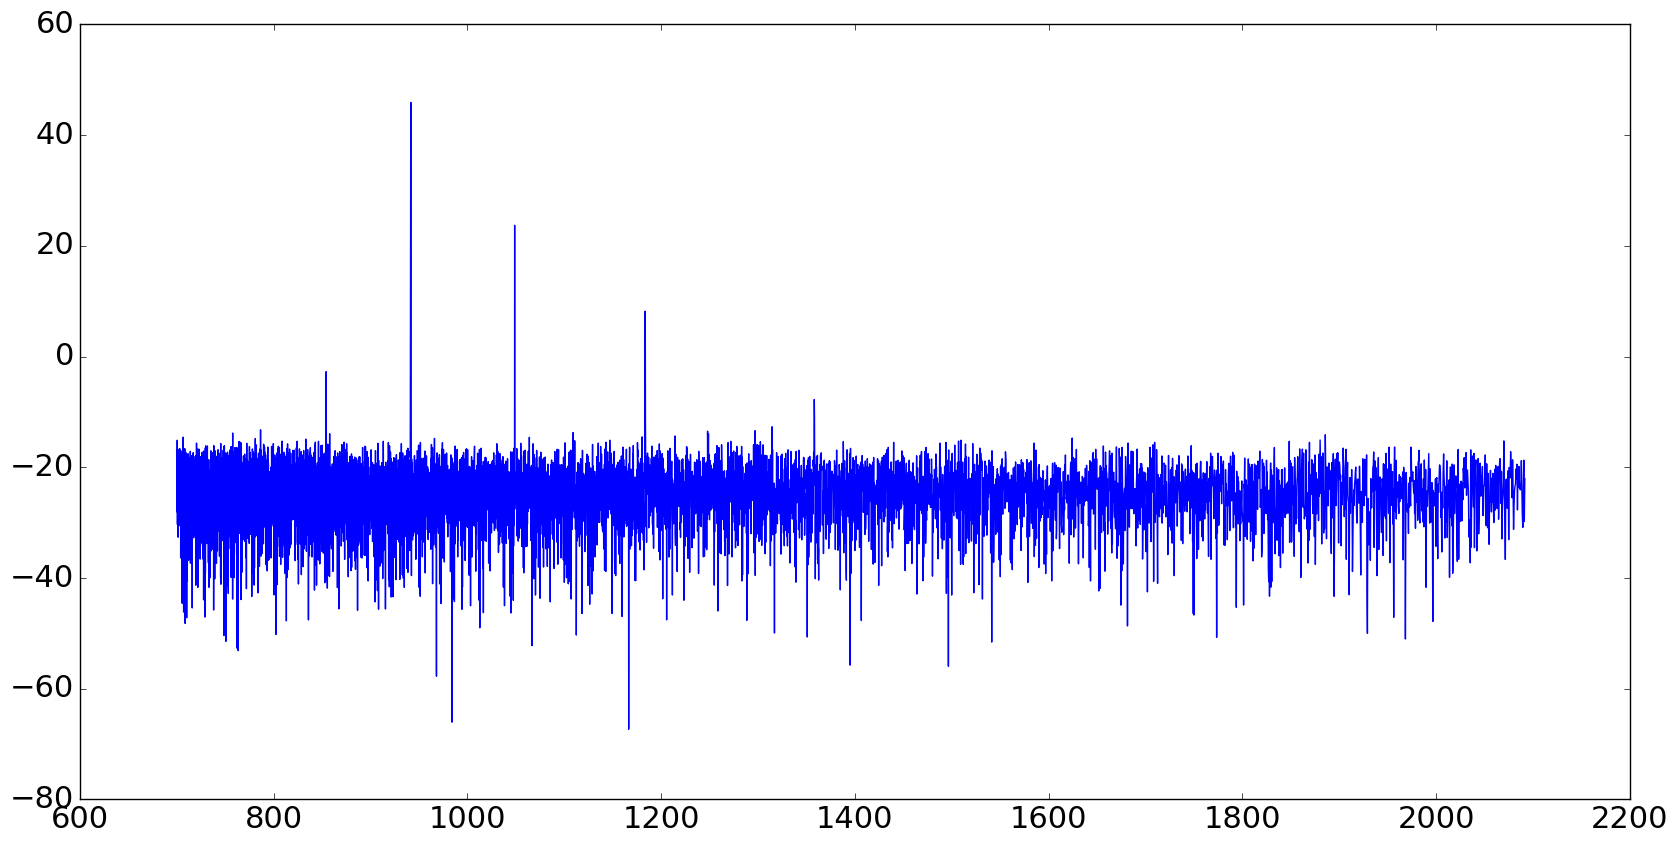

1048.885 941.71760991 6.6 [[ 151.53481917]]


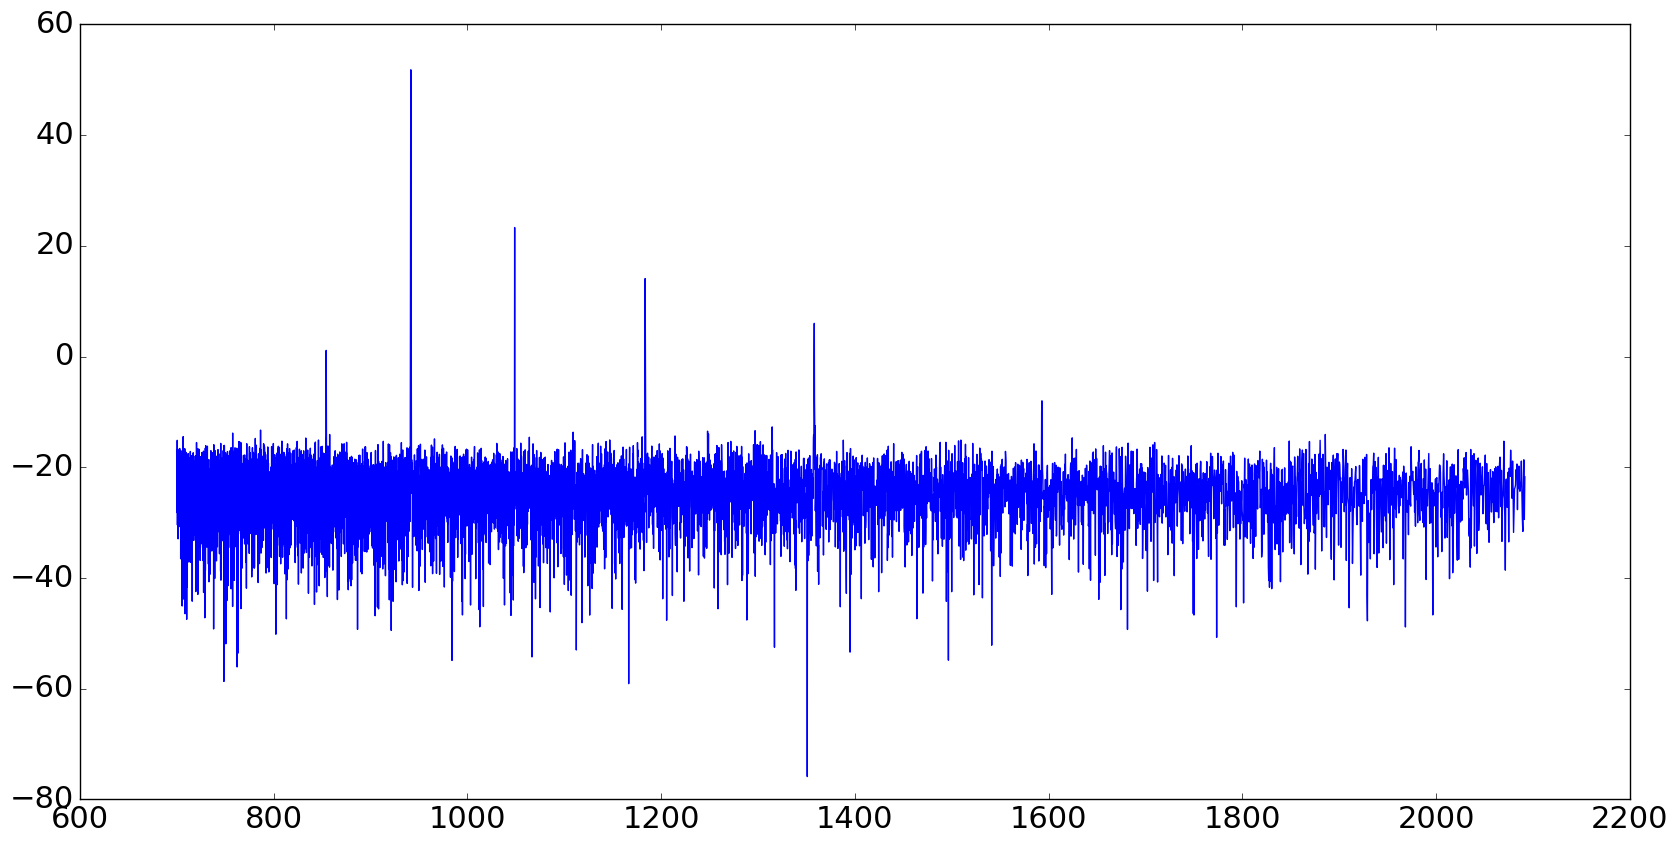

1048.885 941.71760991 6.7 [[ 225.21760639]]


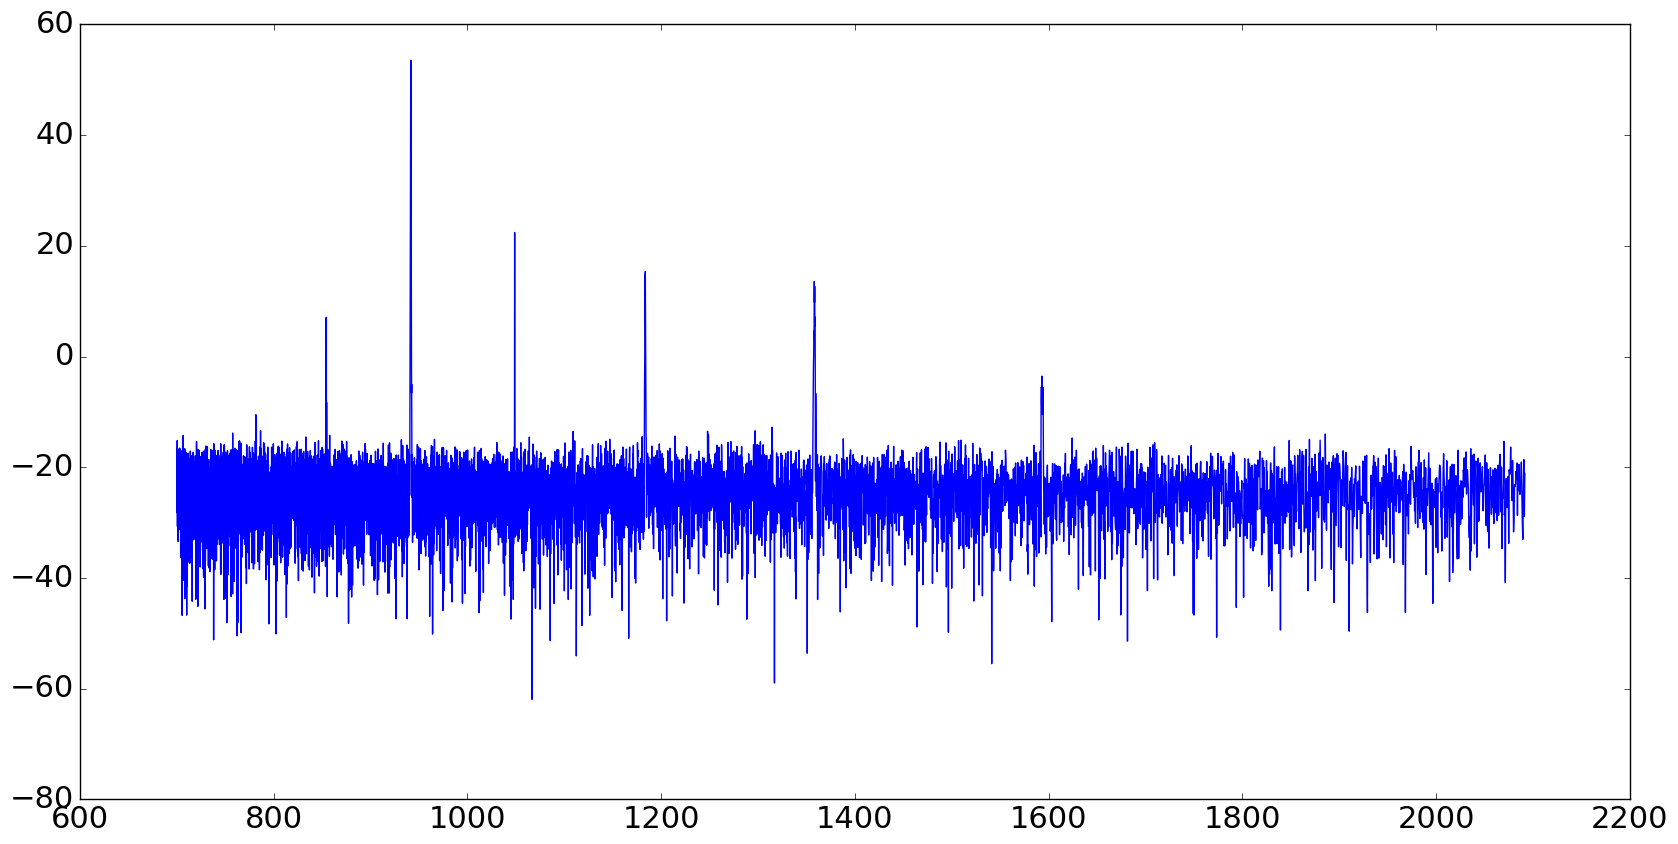

1048.885 941.820527906 6.8 [[ 190.73423105]]


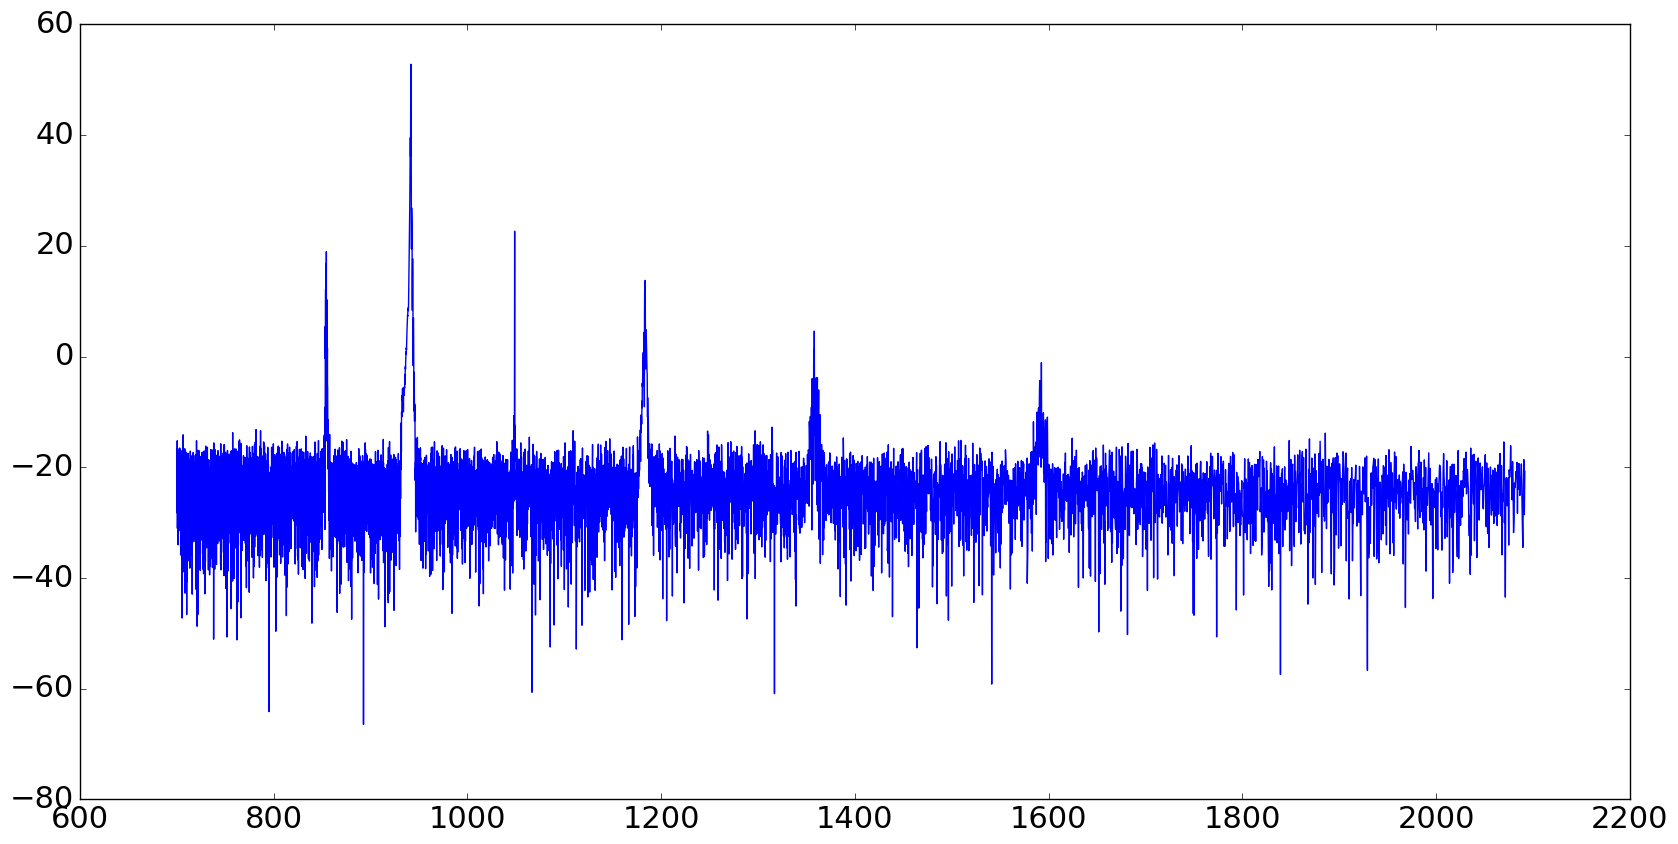

1048.885 941.71760991 6.9 [[ 187.98486438]]


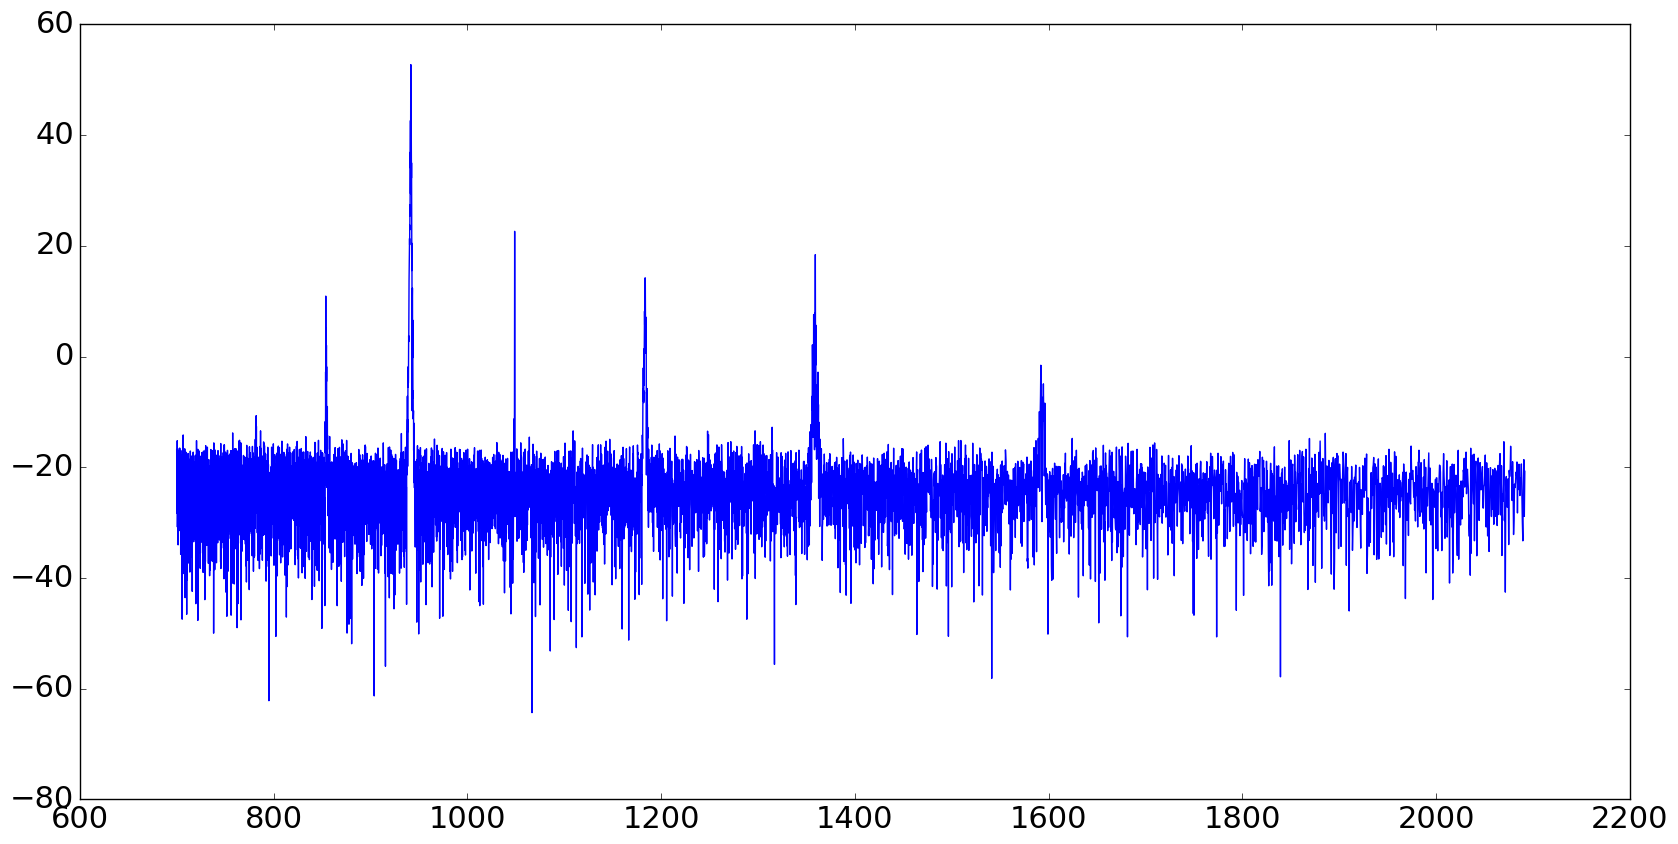

1048.885 941.71760991 7.0 [[ 141.50343581]]


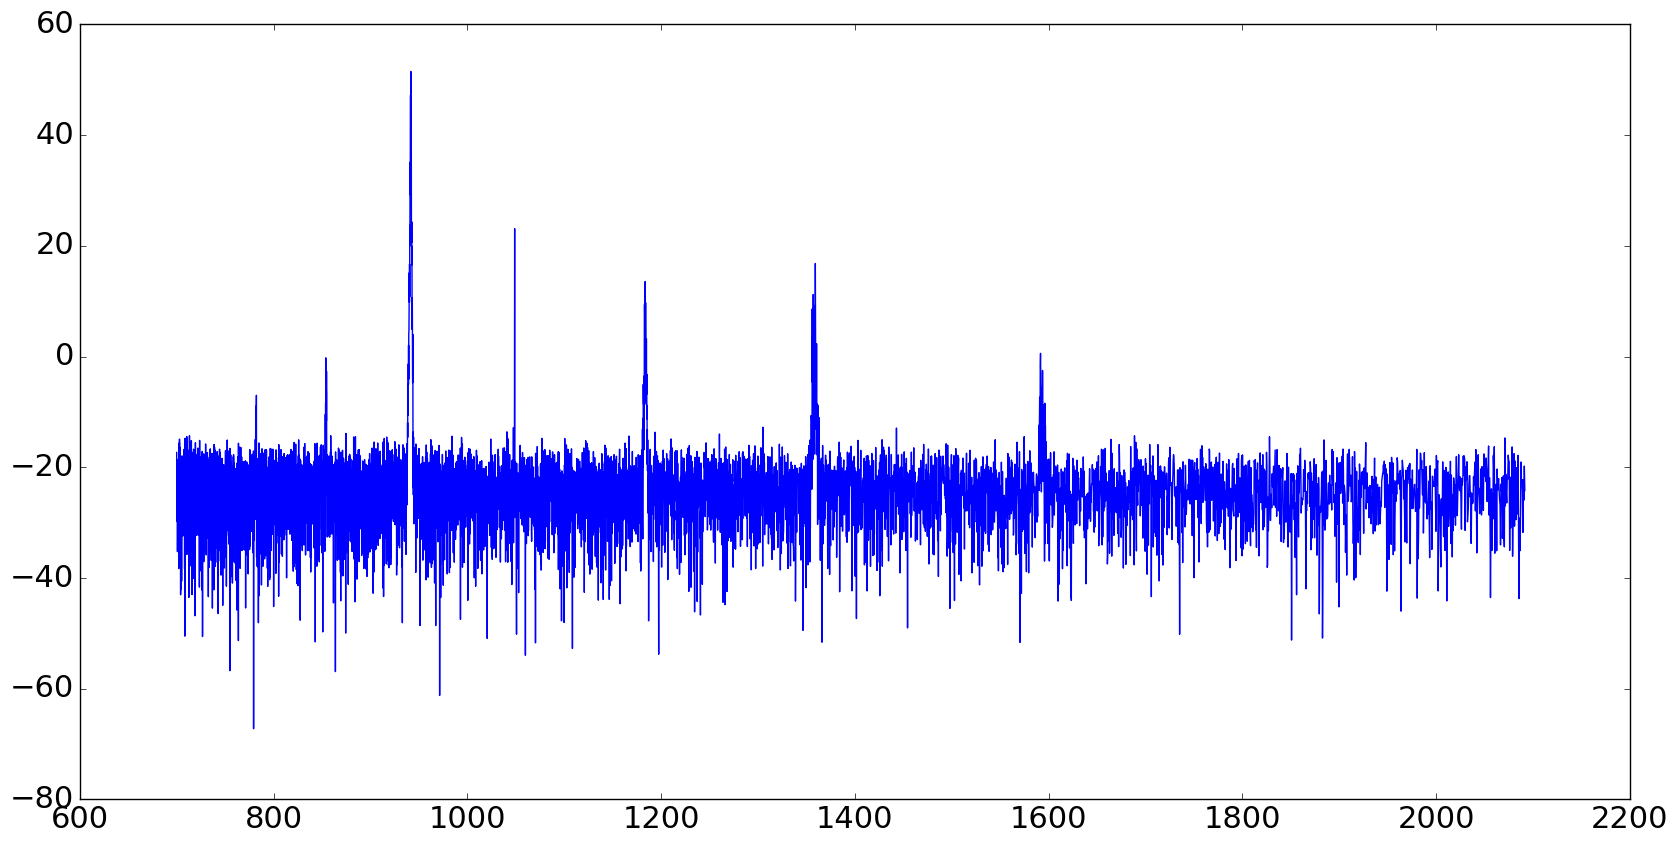

In [6]:
for i in range(31):
    CE = Conversion_efficiency(1,possition = 'portB', filename = 'data_large',filepath = which+'/output'+str(i)+'/data/')
plt.show()

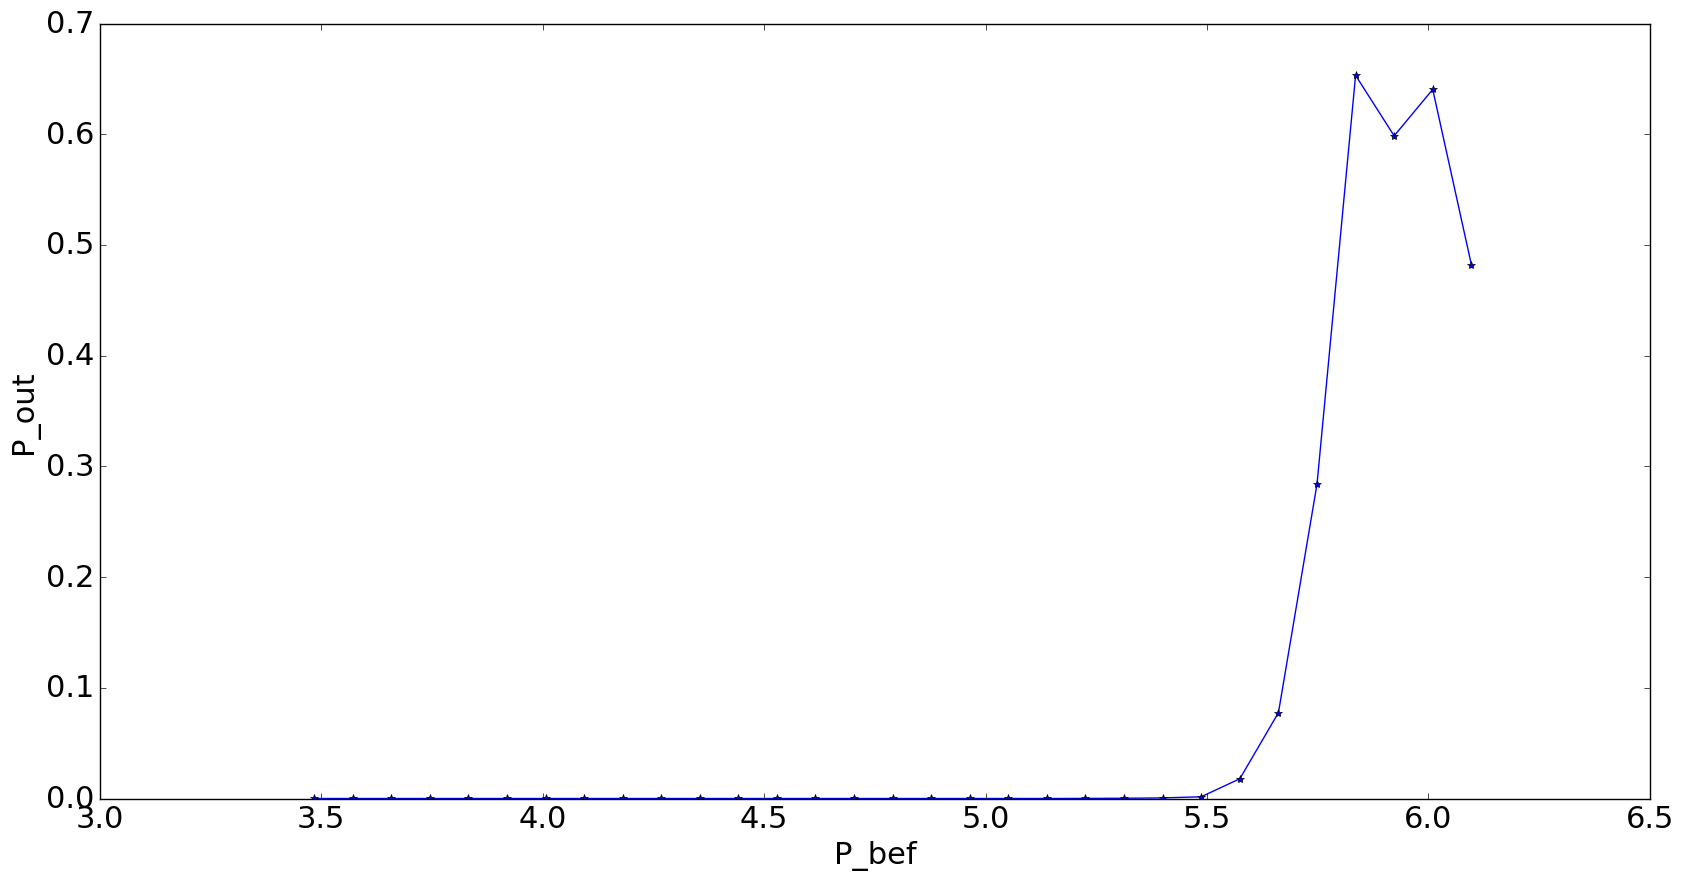

In [7]:
CE.plot_CE('P_bef',var2 = 'P_out')

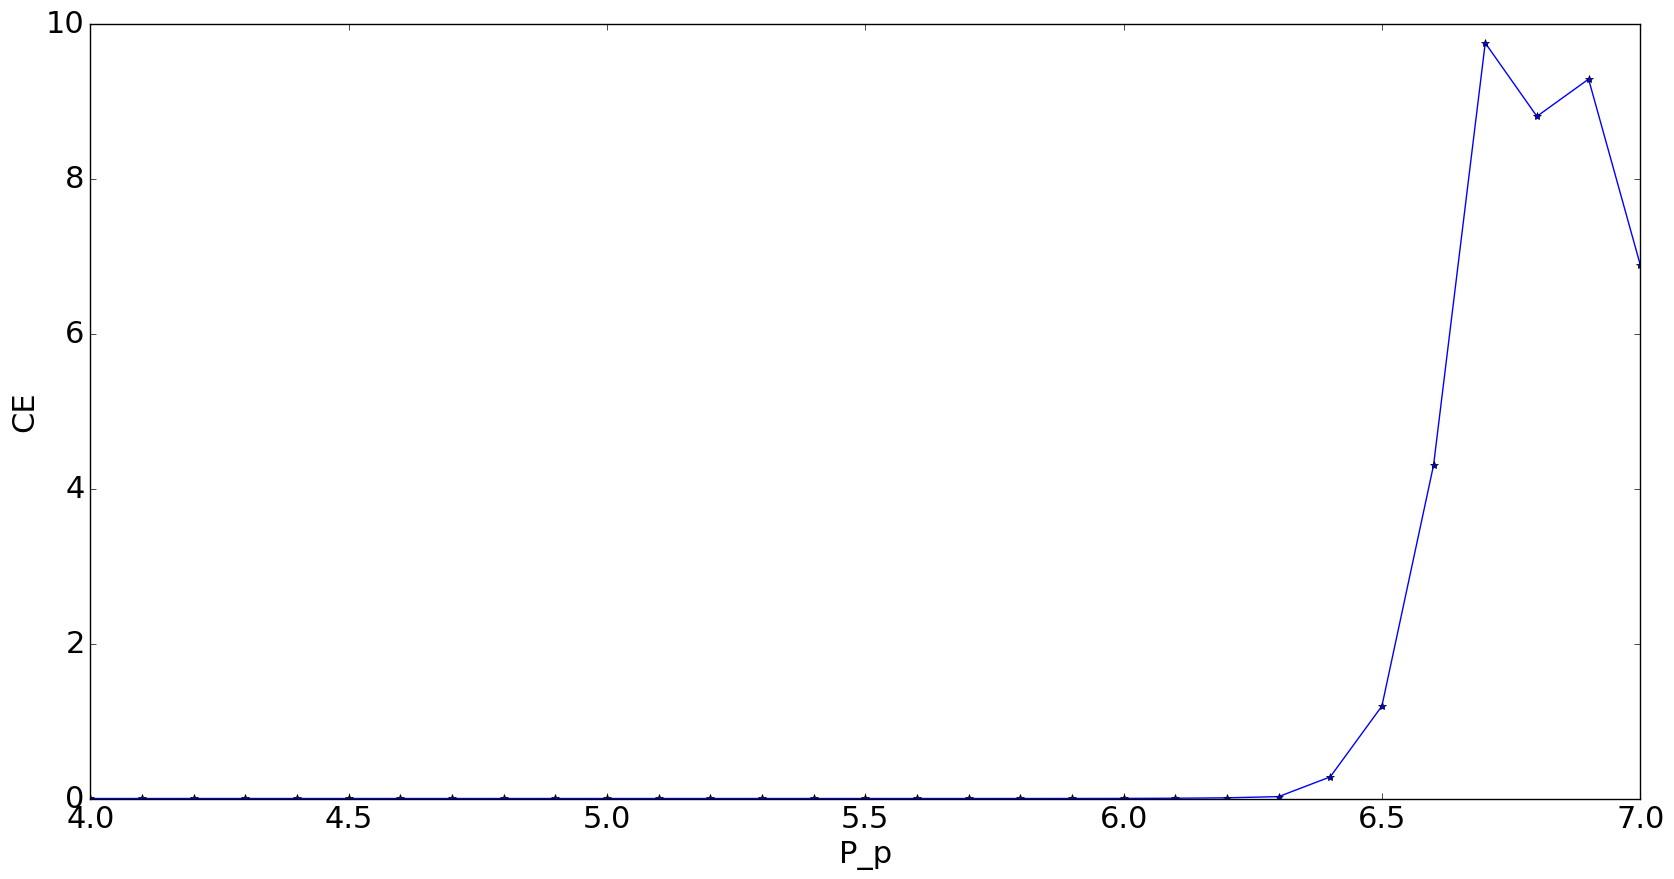

In [9]:
CE.plot_CE('P_p',var2 = 'CE')